In [18]:
import numpy as np
from HH4b import utils
from HH4b import postprocessing
import xgboost as xgb
import importlib
import hist
import os
import mplhep as hep
import matplotlib.pyplot as plt
from HH4b.postprocessing.PostProcess import add_bdt_scores
import HH4b

plt.style.use(hep.style.ROOT)
from HH4b.hh_vars import txbbsfs_decorr_pt_bins, txbbsfs_decorr_txbb_wps
import json

In [19]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
package_path = os.path.dirname(HH4b.__file__)
legacy_label = "Legacy"
mass_var = "H2PNetMass"
bdt_model_name = "24May31_lr_0p02_md_8_AK4Away"
bdt_config = "24May31_lr_0p02_md_8_AK4Away"
year = "2023"


def get_dataframe(events_dict, year, bdt_model_name, bdt_config):
    bdt_model = xgb.XGBClassifier()
    bdt_model.load_model(
        fname=f"{package_path}/boosted/bdt_trainings_run3/{bdt_model_name}/trained_bdt.model"
    )
    make_bdt_dataframe = importlib.import_module(
        f".{bdt_config}", package="HH4b.boosted.bdt_trainings_run3"
    )

    bdt_events_dict = {}
    for key in events_dict:
        events = events_dict[key]
        bdt_events = make_bdt_dataframe.bdt_dataframe(events)
        preds = bdt_model.predict_proba(bdt_events)
        # inference
        add_bdt_scores(bdt_events, preds)

        # extra variables
        bdt_events["H1PNetMass"] = events["bbFatJetPNetMassLegacy"][0]
        bdt_events["H2PNetMass"] = events["bbFatJetPNetMassLegacy"][1]
        bdt_events["H1Msd"] = events["bbFatJetMsd"][0]
        bdt_events["H1TXbb"] = events[f"bbFatJetPNetTXbb{legacy_label}"][0]
        bdt_events["H2TXbb"] = events[f"bbFatJetPNetTXbb{legacy_label}"][1]
        bdt_events["weight"] = events["finalWeight"].to_numpy()

        bdt_events["hlt"] = np.any(
            np.array(
                [events[trigger][0] for trigger in postprocessing.HLTs[year] if trigger in events]
            ),
            axis=0,
        )
        mask_hlt = bdt_events["hlt"] == 1

        # masks
        mask_presel = (
            (bdt_events["H1Msd"] > 40)
            & (bdt_events["H1Pt"] > 300)
            & (bdt_events["H2Pt"] > 250)
            & (bdt_events["H1TXbb"] > 0.8)
        )
        mask_mass = (bdt_events["H2PNetMass"] > 50) & (bdt_events["H2PNetMass"] < 250)
        bdt_events = bdt_events[(mask_mass) & (mask_hlt) & (mask_presel)]

        columns = [
            "bdt_score",
            "H1TXbb",
            "H2TXbb",
            "H1PNetMass",
            "H2PNetMass",
            "weight",
            "H1Pt",
            "H2Pt",
        ]
        bdt_events_dict[key] = bdt_events[columns]
    return bdt_events_dict

In [21]:
data_dir = "24May24_v12_private_signal"
input_dir = f"/ceph/cms/store/user/cmantill/bbbb/skimmer/{data_dir}"

samples_run3 = {
    "2022EE": {
        # "data": ["JetMET_Run2022E"],
        "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        # "ttbar": ["TTto"],
        # "qcd": qcd_list,
    },
    "2022": {
        "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        # "ttbar": ["TTto"],
        # "qcd": qcd_list,
    },
    "2023": {
        "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        # "ttbar": ["TTto"],
        # "qcd": qcd_list,
    },
    "2023BPix": {
        "hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        # "ttbar": ["TTto"],
        # "qcd": qcd_list,
    },
}

bdt_events_dict_year = {}
for year in samples_run3:
    events = HH4b.postprocessing.load_run3_samples(
        input_dir=input_dir,
        year=year,
        legacy=True,
        samples_run3=samples_run3,
        reorder_txbb=True,
        txbb=f"bbFatJetPNetTXbb{legacy_label}",
    )
    bdt_events_dict_year[year] = get_dataframe(events, year, bdt_model_name, bdt_config)

Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV


/home/users/woodson/HH4b/src/HH4b/utils.py:240: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events["finalWeight"] = events["weight"] / totals["np_nominal"]
/home/users/woodson/HH4b/src/HH4b/postprocessing/postprocessing.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict_syst[key][("bbFatJetPNetMassLegacyRaw", 0)] = x[:, 0]


Loaded GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV: 155470 entries


/home/users/woodson/HH4b/src/HH4b/postprocessing/postprocessing.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict_syst[key][("bbFatJetPNetMassLegacyRaw", 1)] = x[:, 1]
/home/users/woodson/HH4b/src/HH4b/postprocessing/postprocessing.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[key][(f"bbFatJetPNetMassLegacy_{skey}_{shift}", i)] = x_smear[
/home/users/woodson/HH4b/src/HH4b/postprocessing/postprocessing.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

scaling and smearing mass for hh4b 2022EE
Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV


/home/users/woodson/HH4b/src/HH4b/utils.py:240: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events["finalWeight"] = events["weight"] / totals["np_nominal"]
/home/users/woodson/HH4b/src/HH4b/postprocessing/postprocessing.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict_syst[key][("bbFatJetPNetMassLegacyRaw", 0)] = x[:, 0]
/home/users/woodson/HH4b/src/HH4b/postprocessing/postprocessing.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

Loaded GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV: 48963 entries
scaling and smearing mass for hh4b 2022
Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV


/home/users/woodson/HH4b/src/HH4b/utils.py:240: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events["finalWeight"] = events["weight"] / totals["np_nominal"]
/home/users/woodson/HH4b/src/HH4b/postprocessing/postprocessing.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict_syst[key][("bbFatJetPNetMassLegacyRaw", 0)] = x[:, 0]
/home/users/woodson/HH4b/src/HH4b/postprocessing/postprocessing.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

Loaded GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV: 139949 entries
scaling and smearing mass for hh4b 2023


/home/users/woodson/HH4b/src/HH4b/postprocessing/postprocessing.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[key][(f"bbFatJetPNetMassLegacy_{skey}_{shift}", i)] = x_smear[
/home/users/woodson/HH4b/src/HH4b/postprocessing/postprocessing.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[key][(f"bbFatJetPNetMassLegacy_{skey}_{shift}", i)] = x_smear[
/home/users/woodson/HH4b/src/HH4b/postprocessing/postprocessing.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV


/home/users/woodson/HH4b/src/HH4b/utils.py:240: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events["finalWeight"] = events["weight"] / totals["np_nominal"]
/home/users/woodson/HH4b/src/HH4b/postprocessing/postprocessing.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict_syst[key][("bbFatJetPNetMassLegacyRaw", 0)] = x[:, 0]
/home/users/woodson/HH4b/src/HH4b/postprocessing/postprocessing.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

Loaded GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV: 60797 entries
scaling and smearing mass for hh4b 2023BPix


In [22]:
events_combined, scaled_by = postprocessing.combine_run3_samples(
    bdt_events_dict_year,
    ["hh4b"],
    bg_keys=["ttbar"],
    scale_processes={},
    years_run3=bdt_events_dict_year.keys(),
)

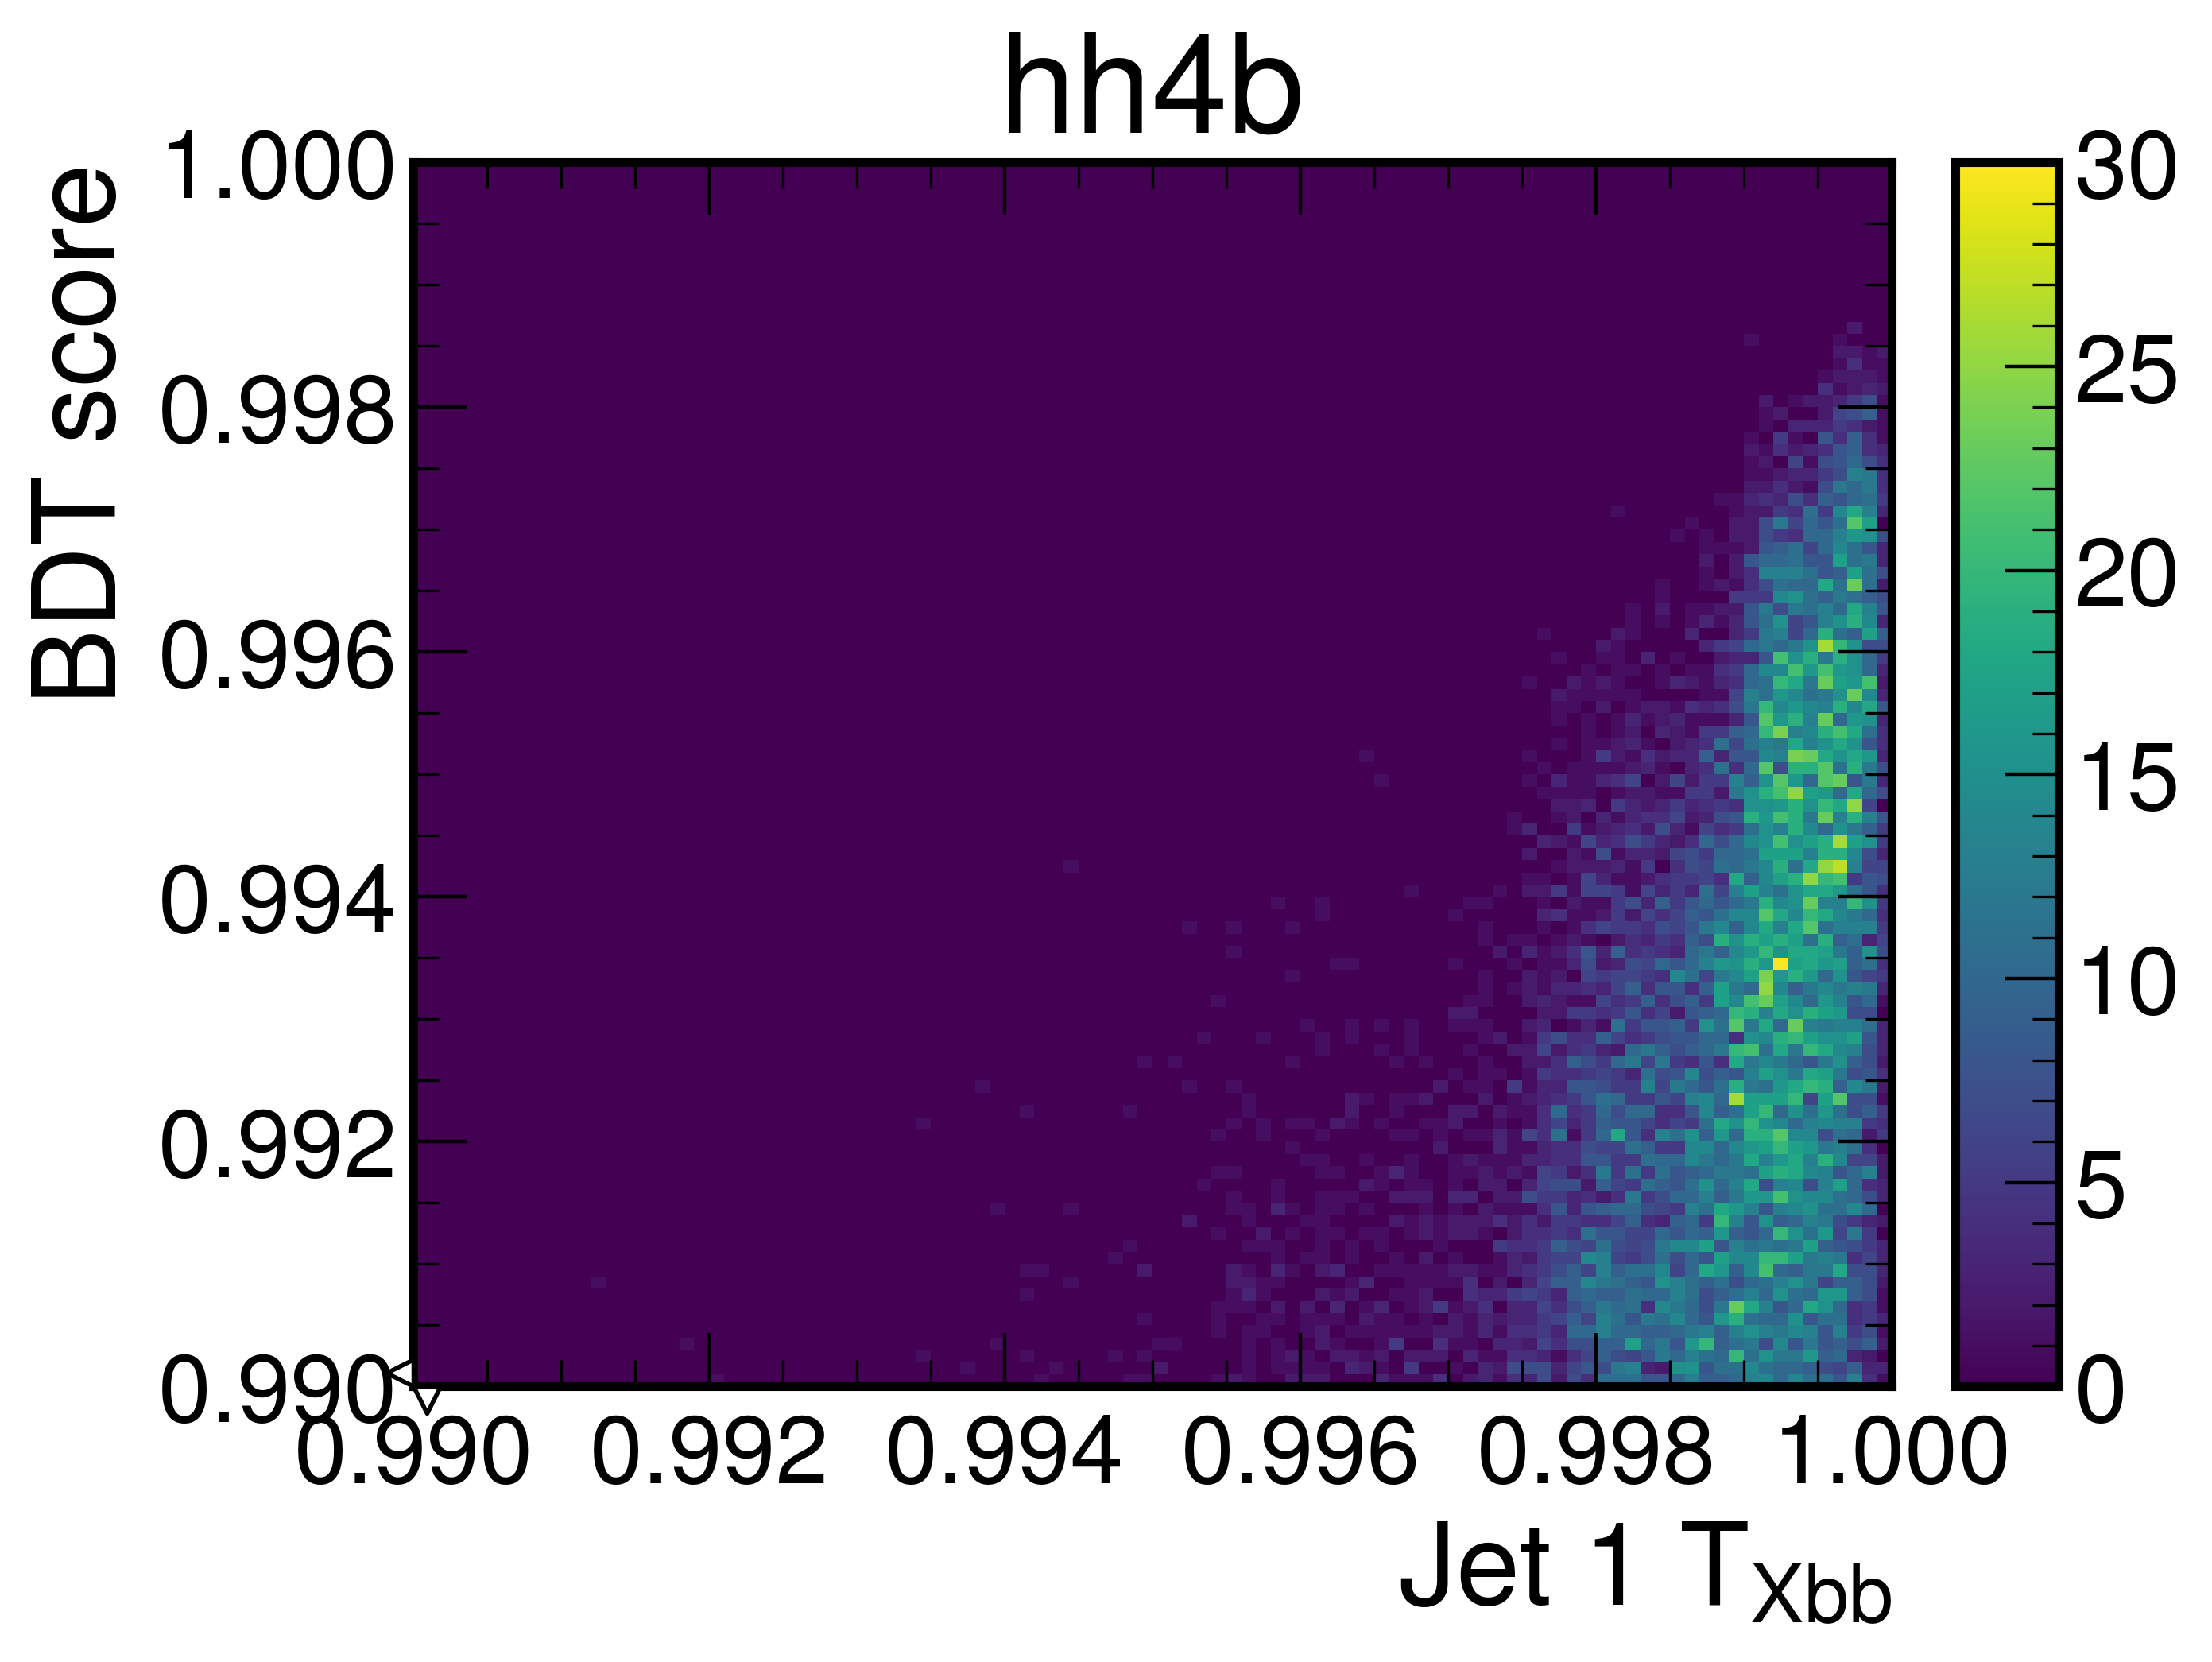

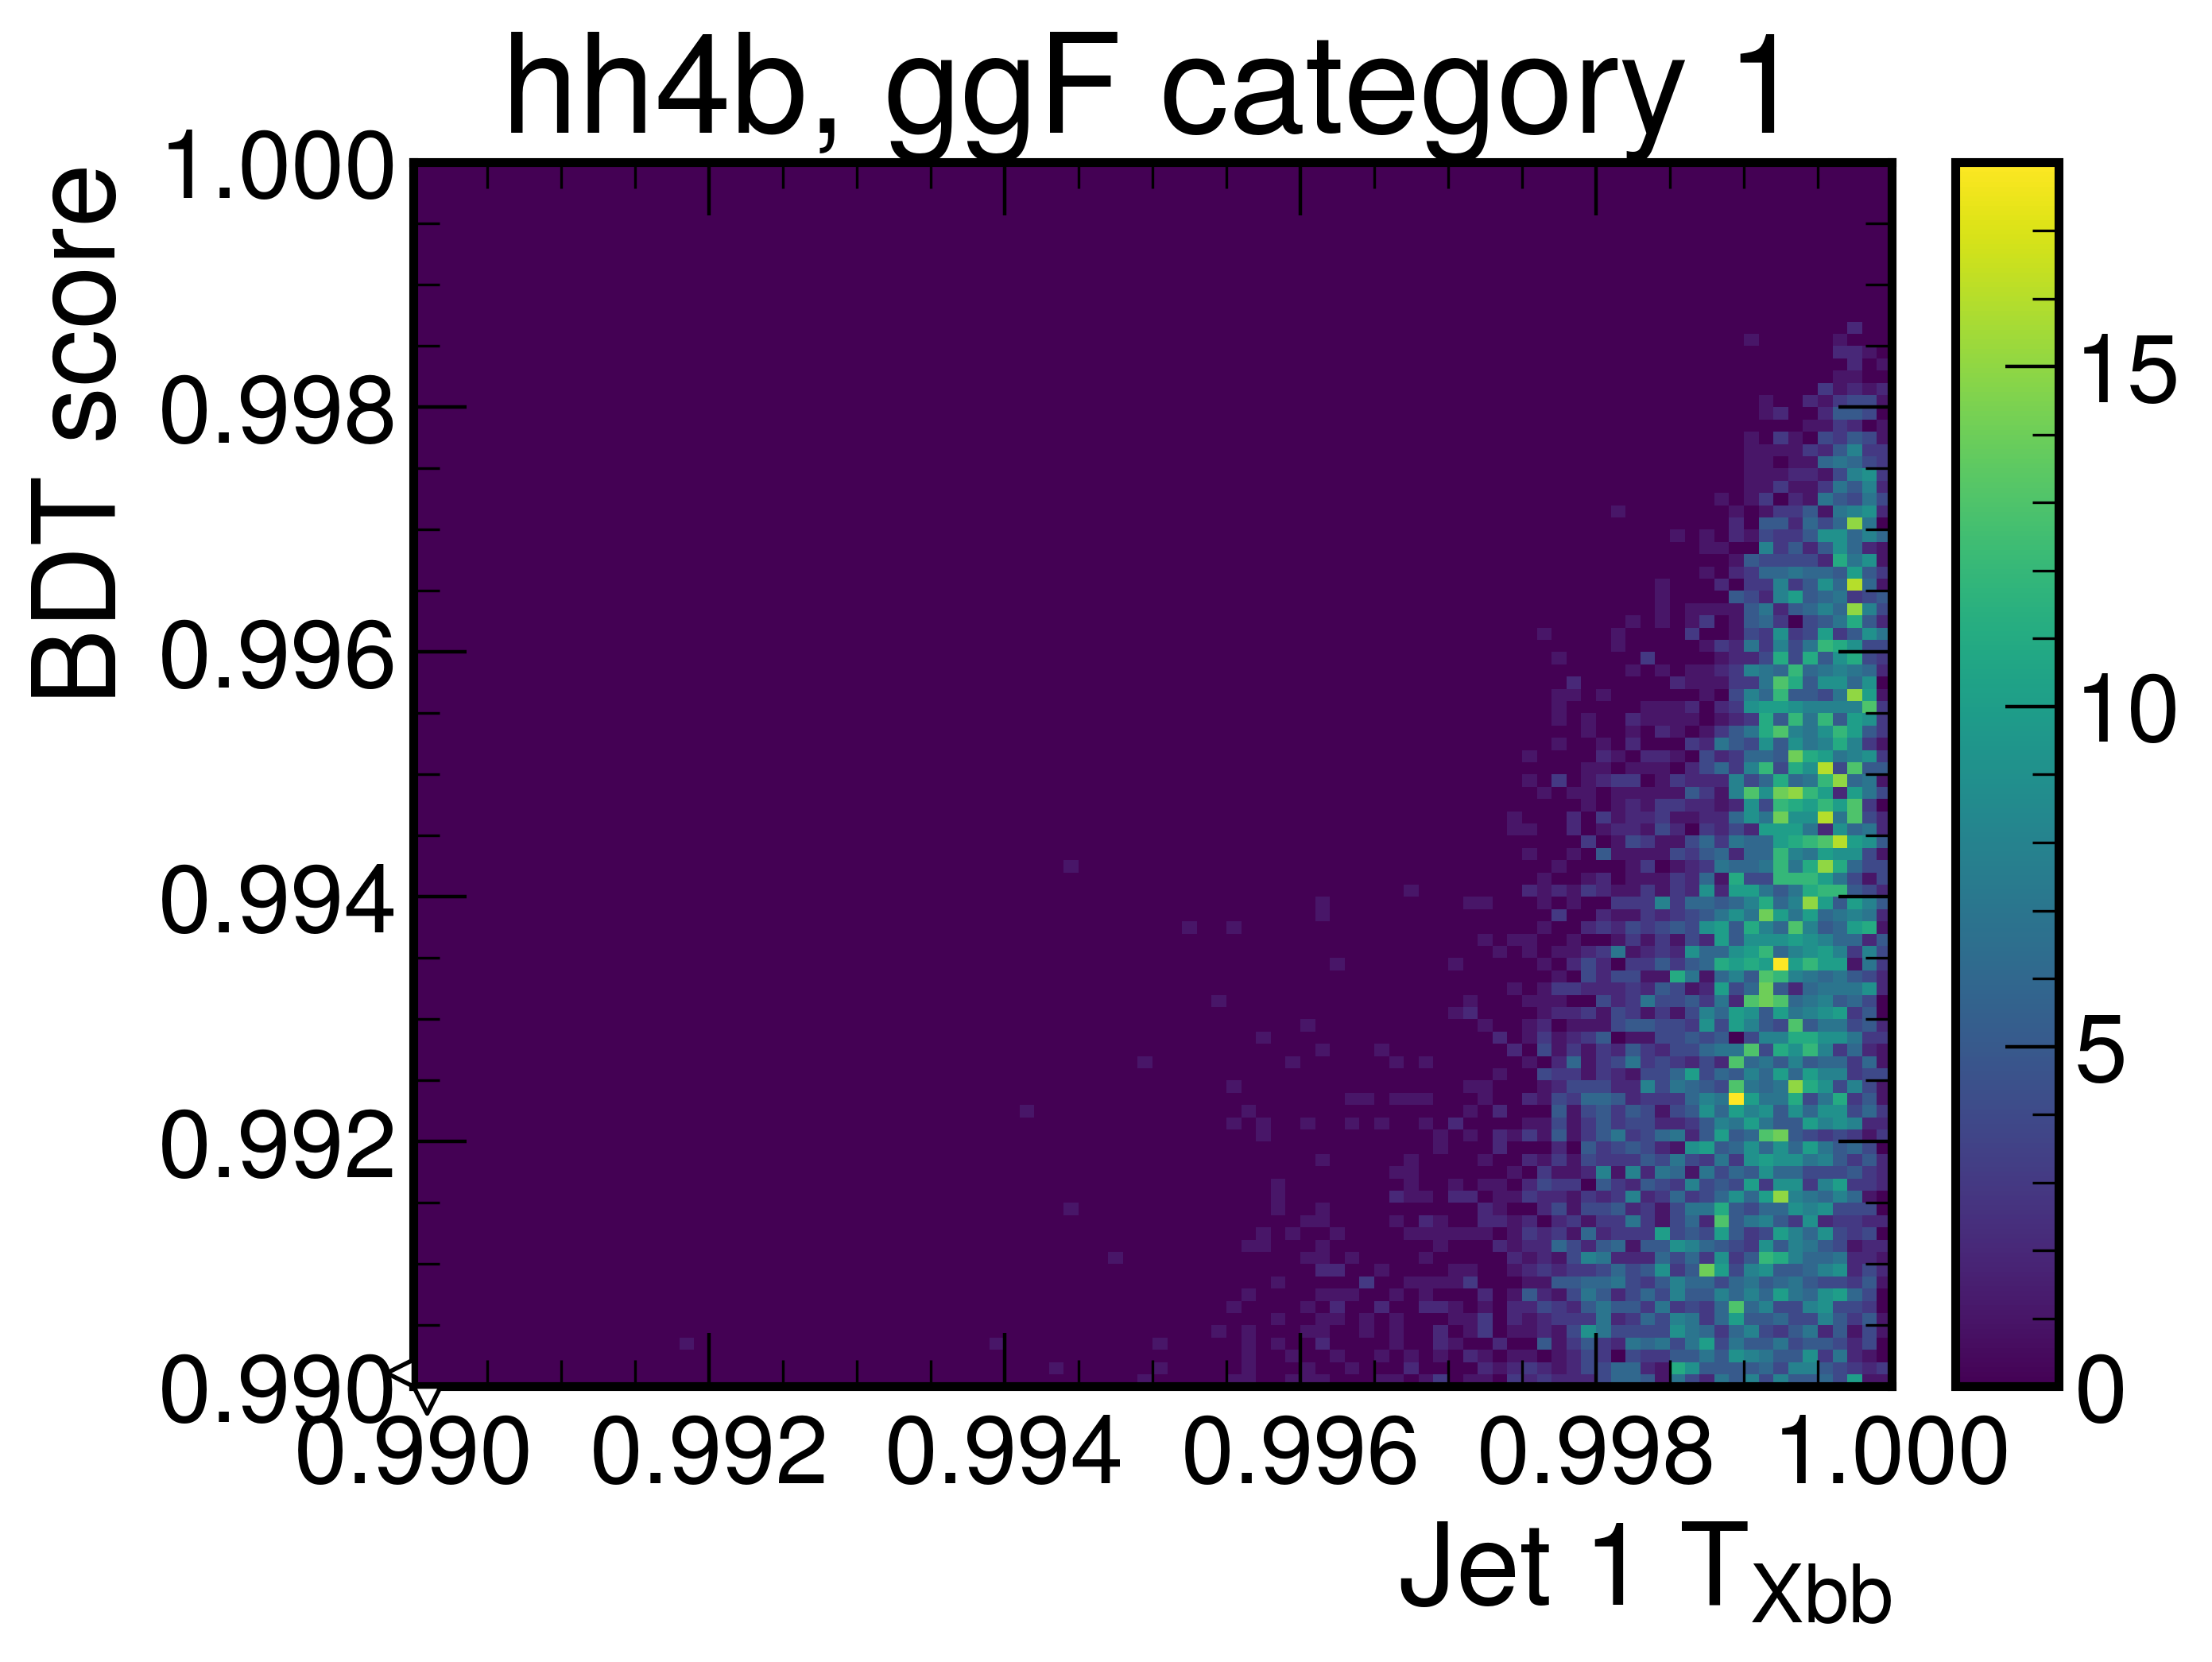

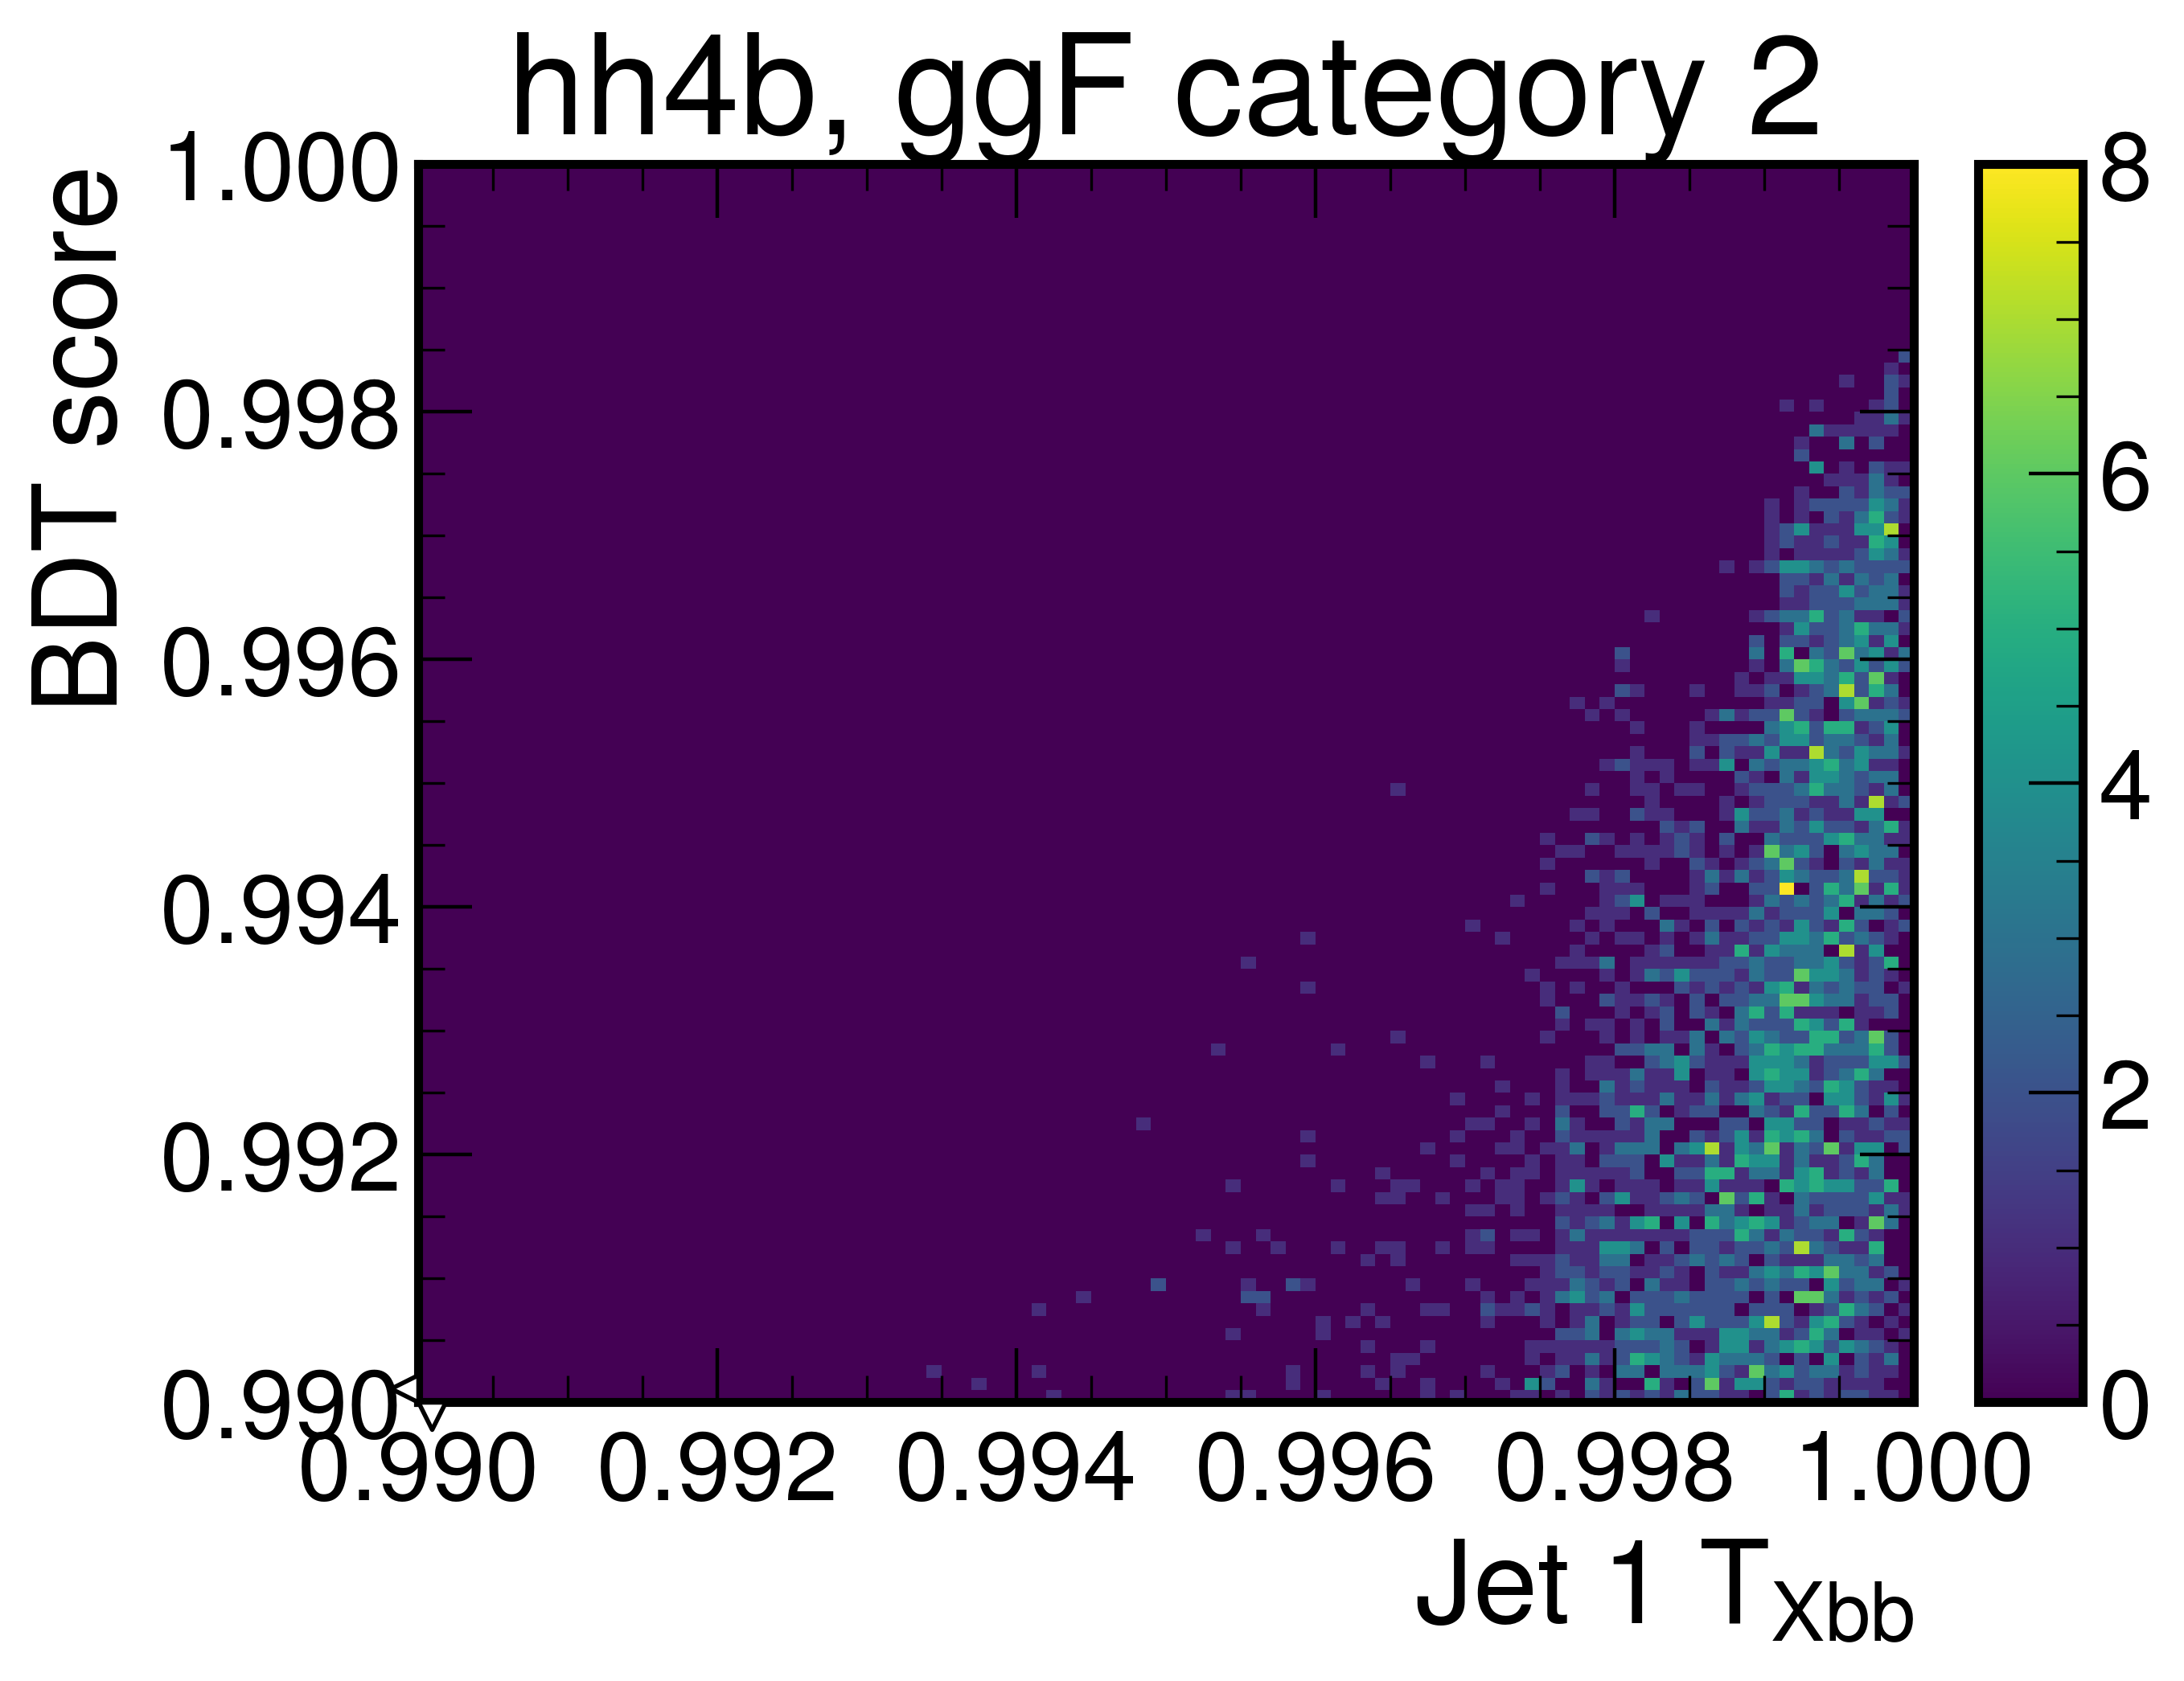

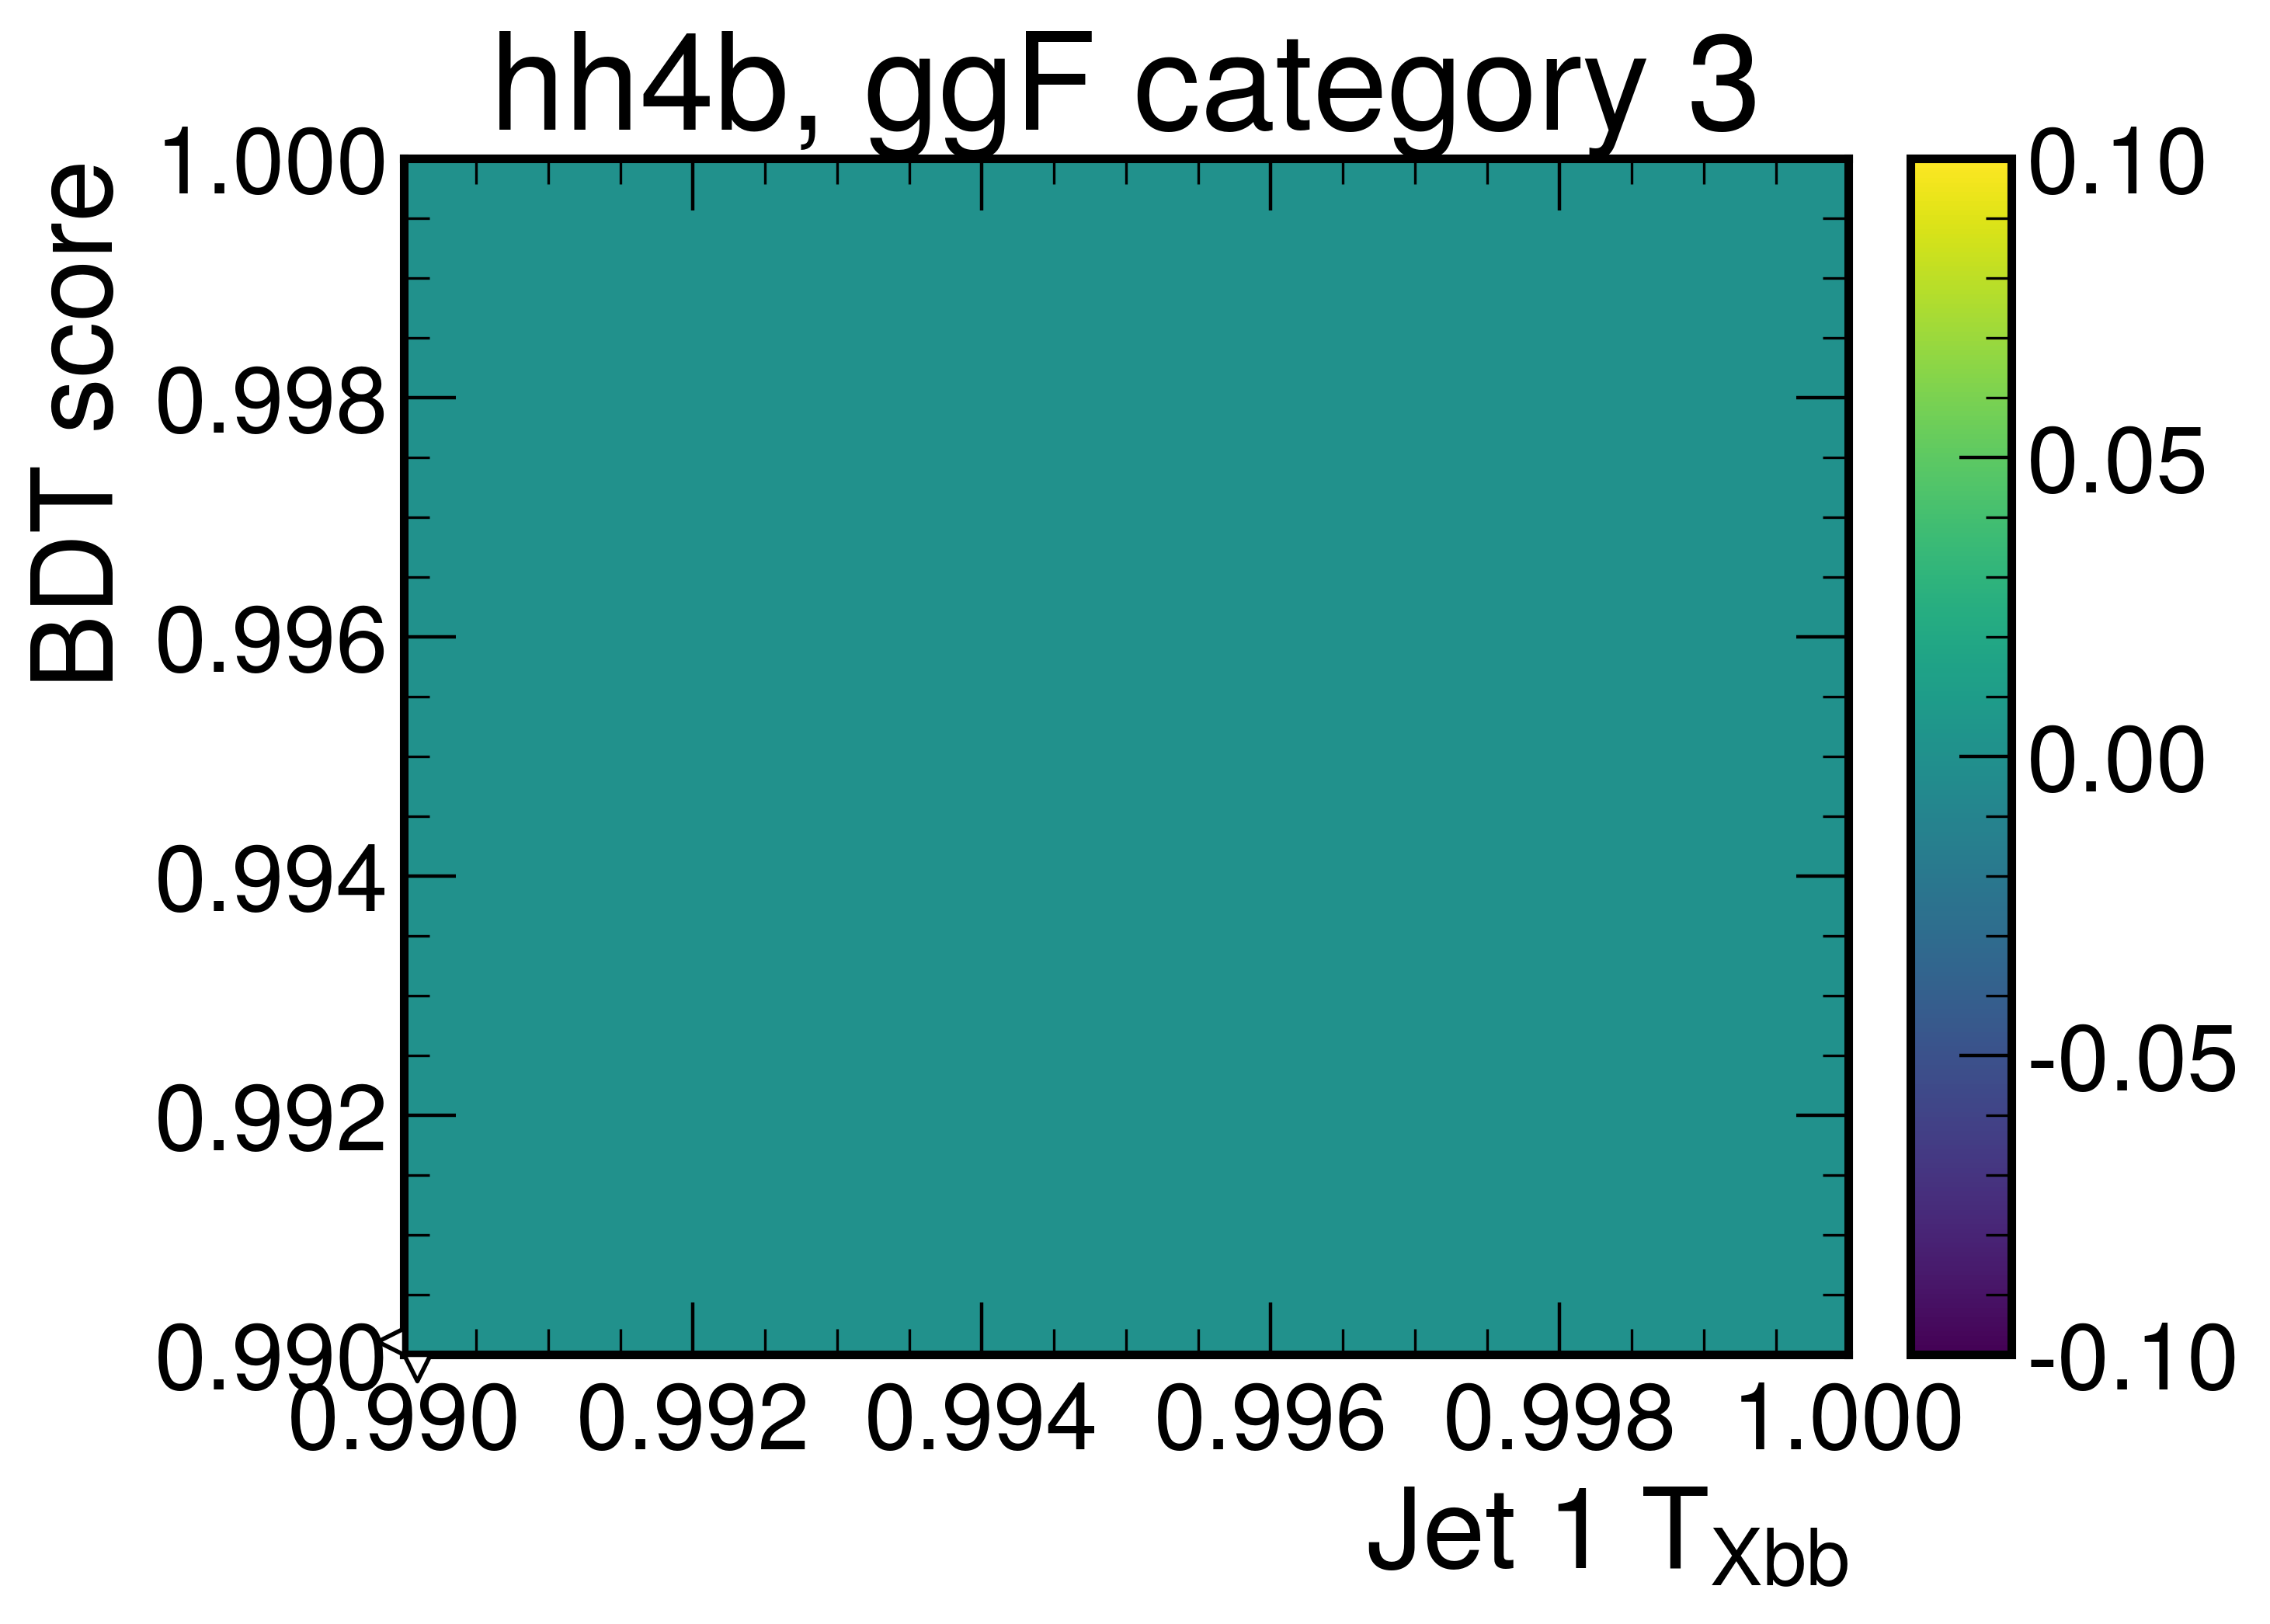

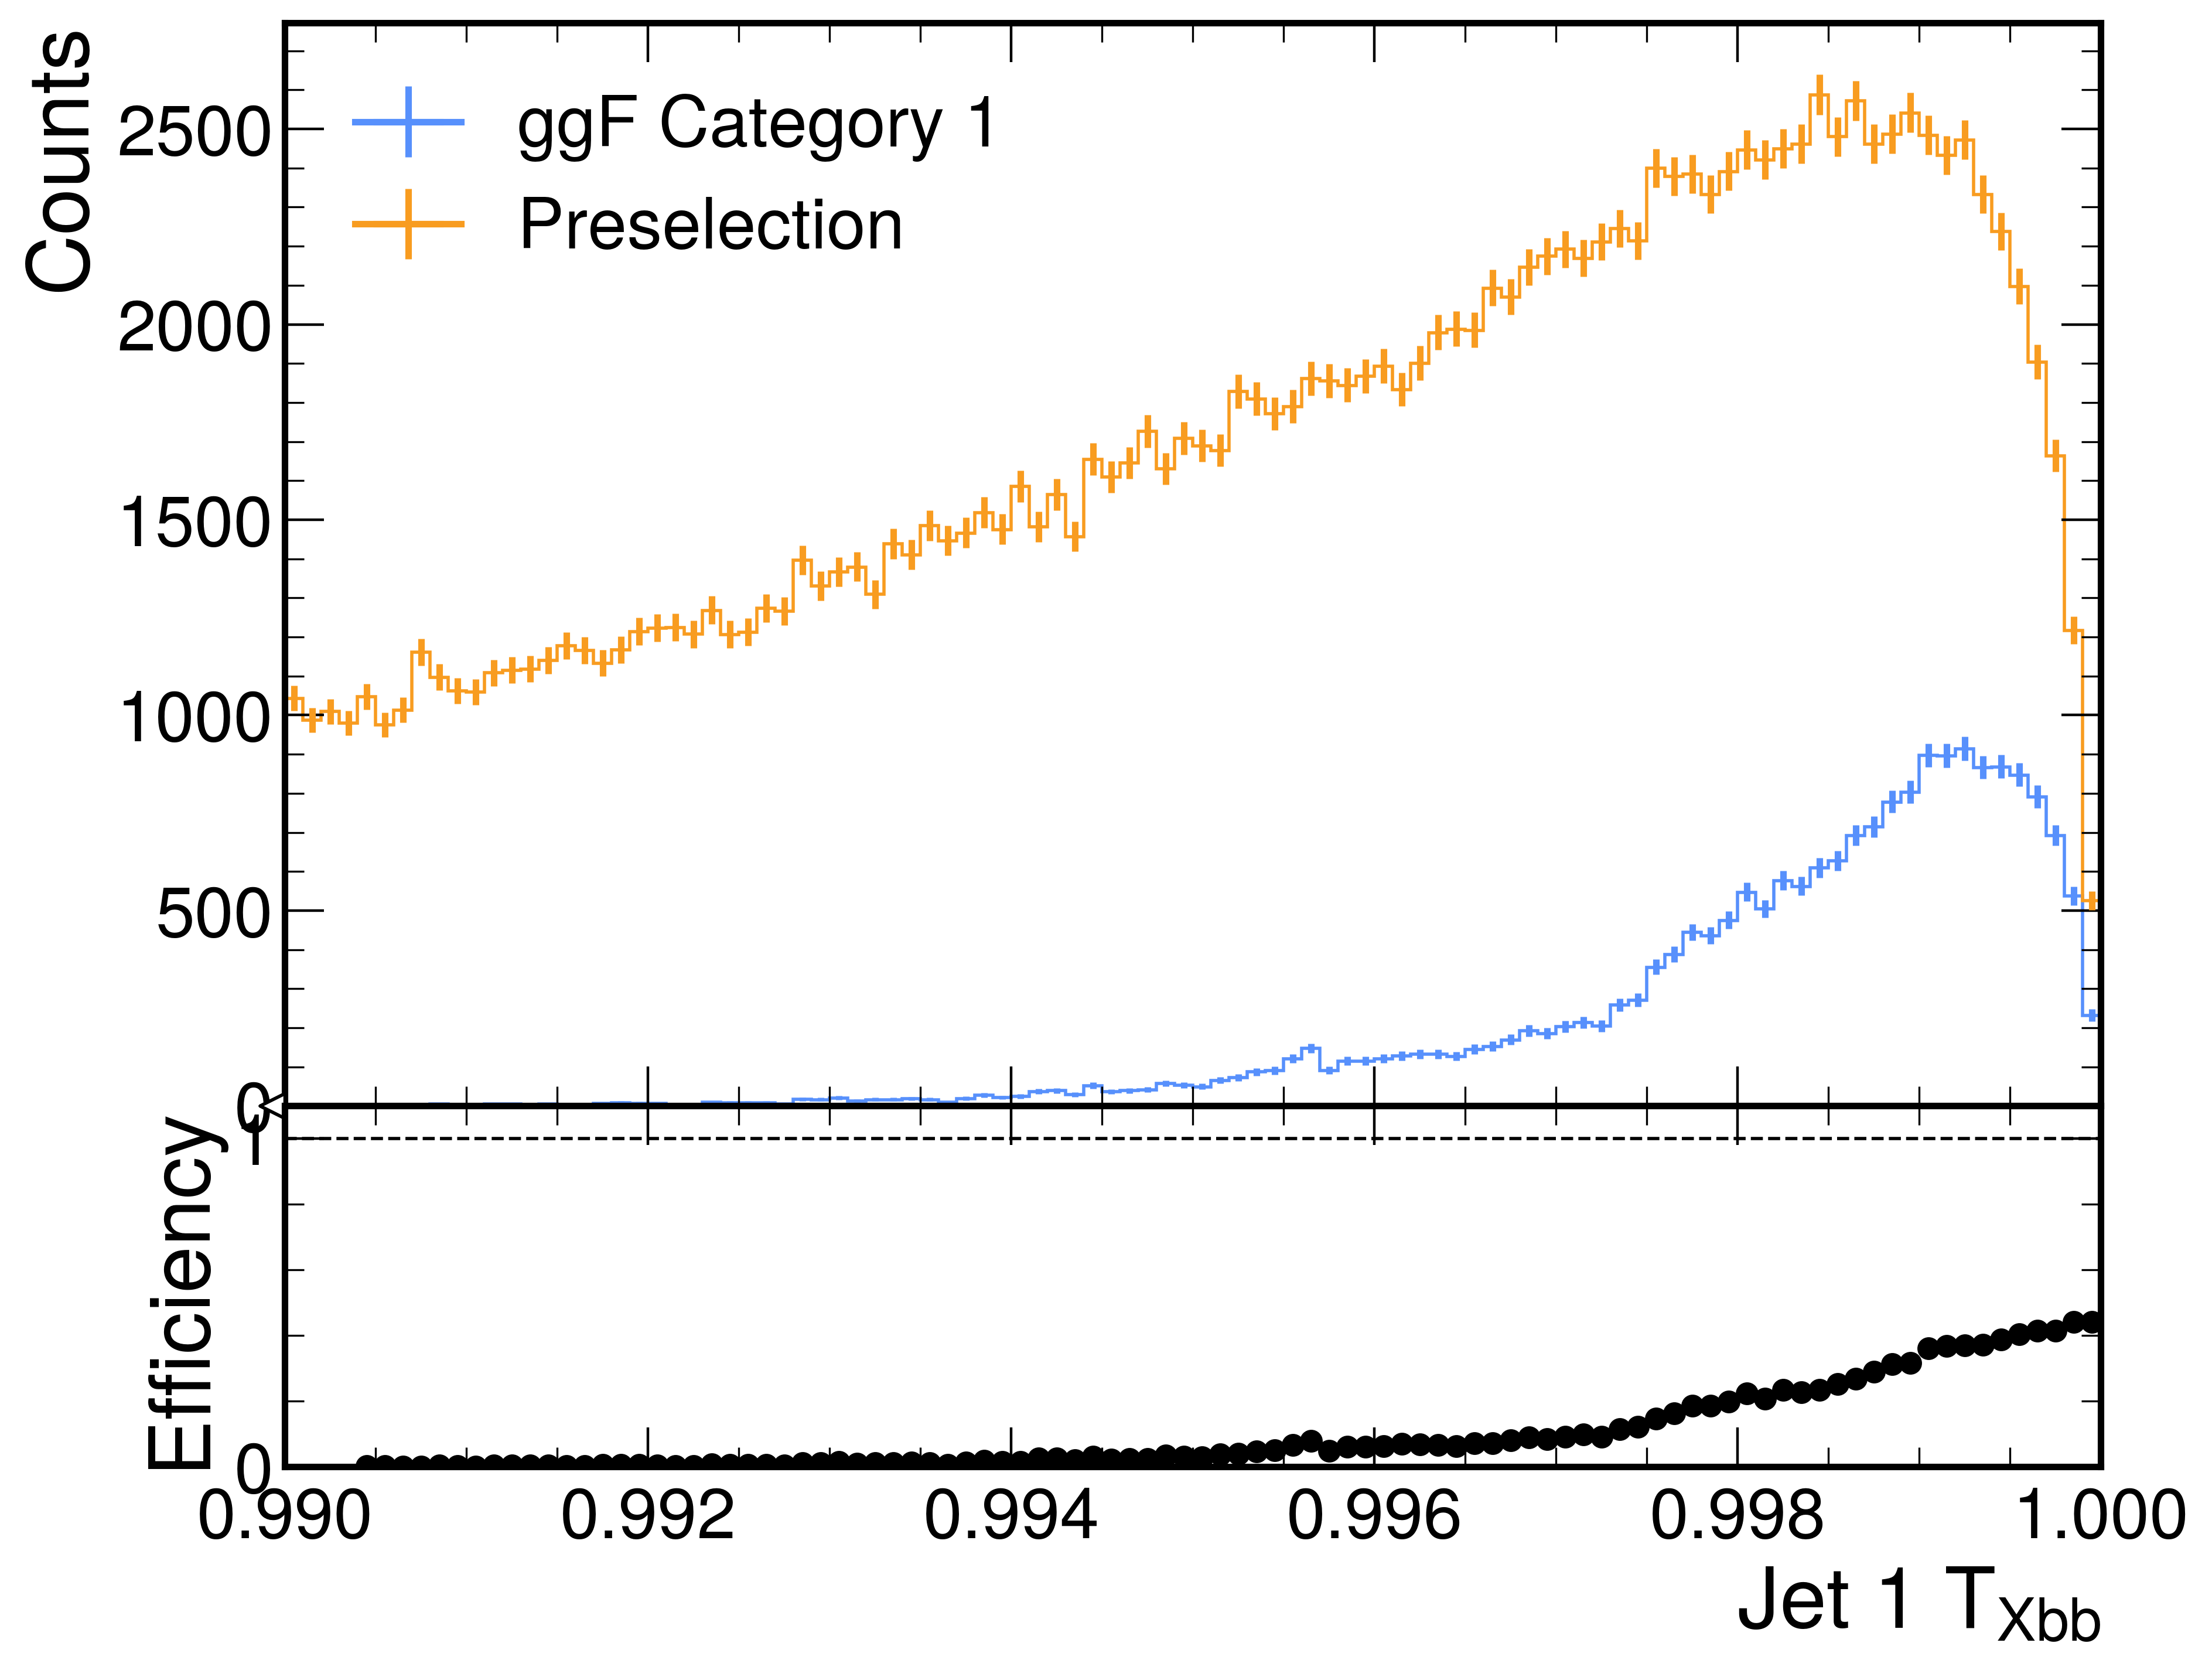

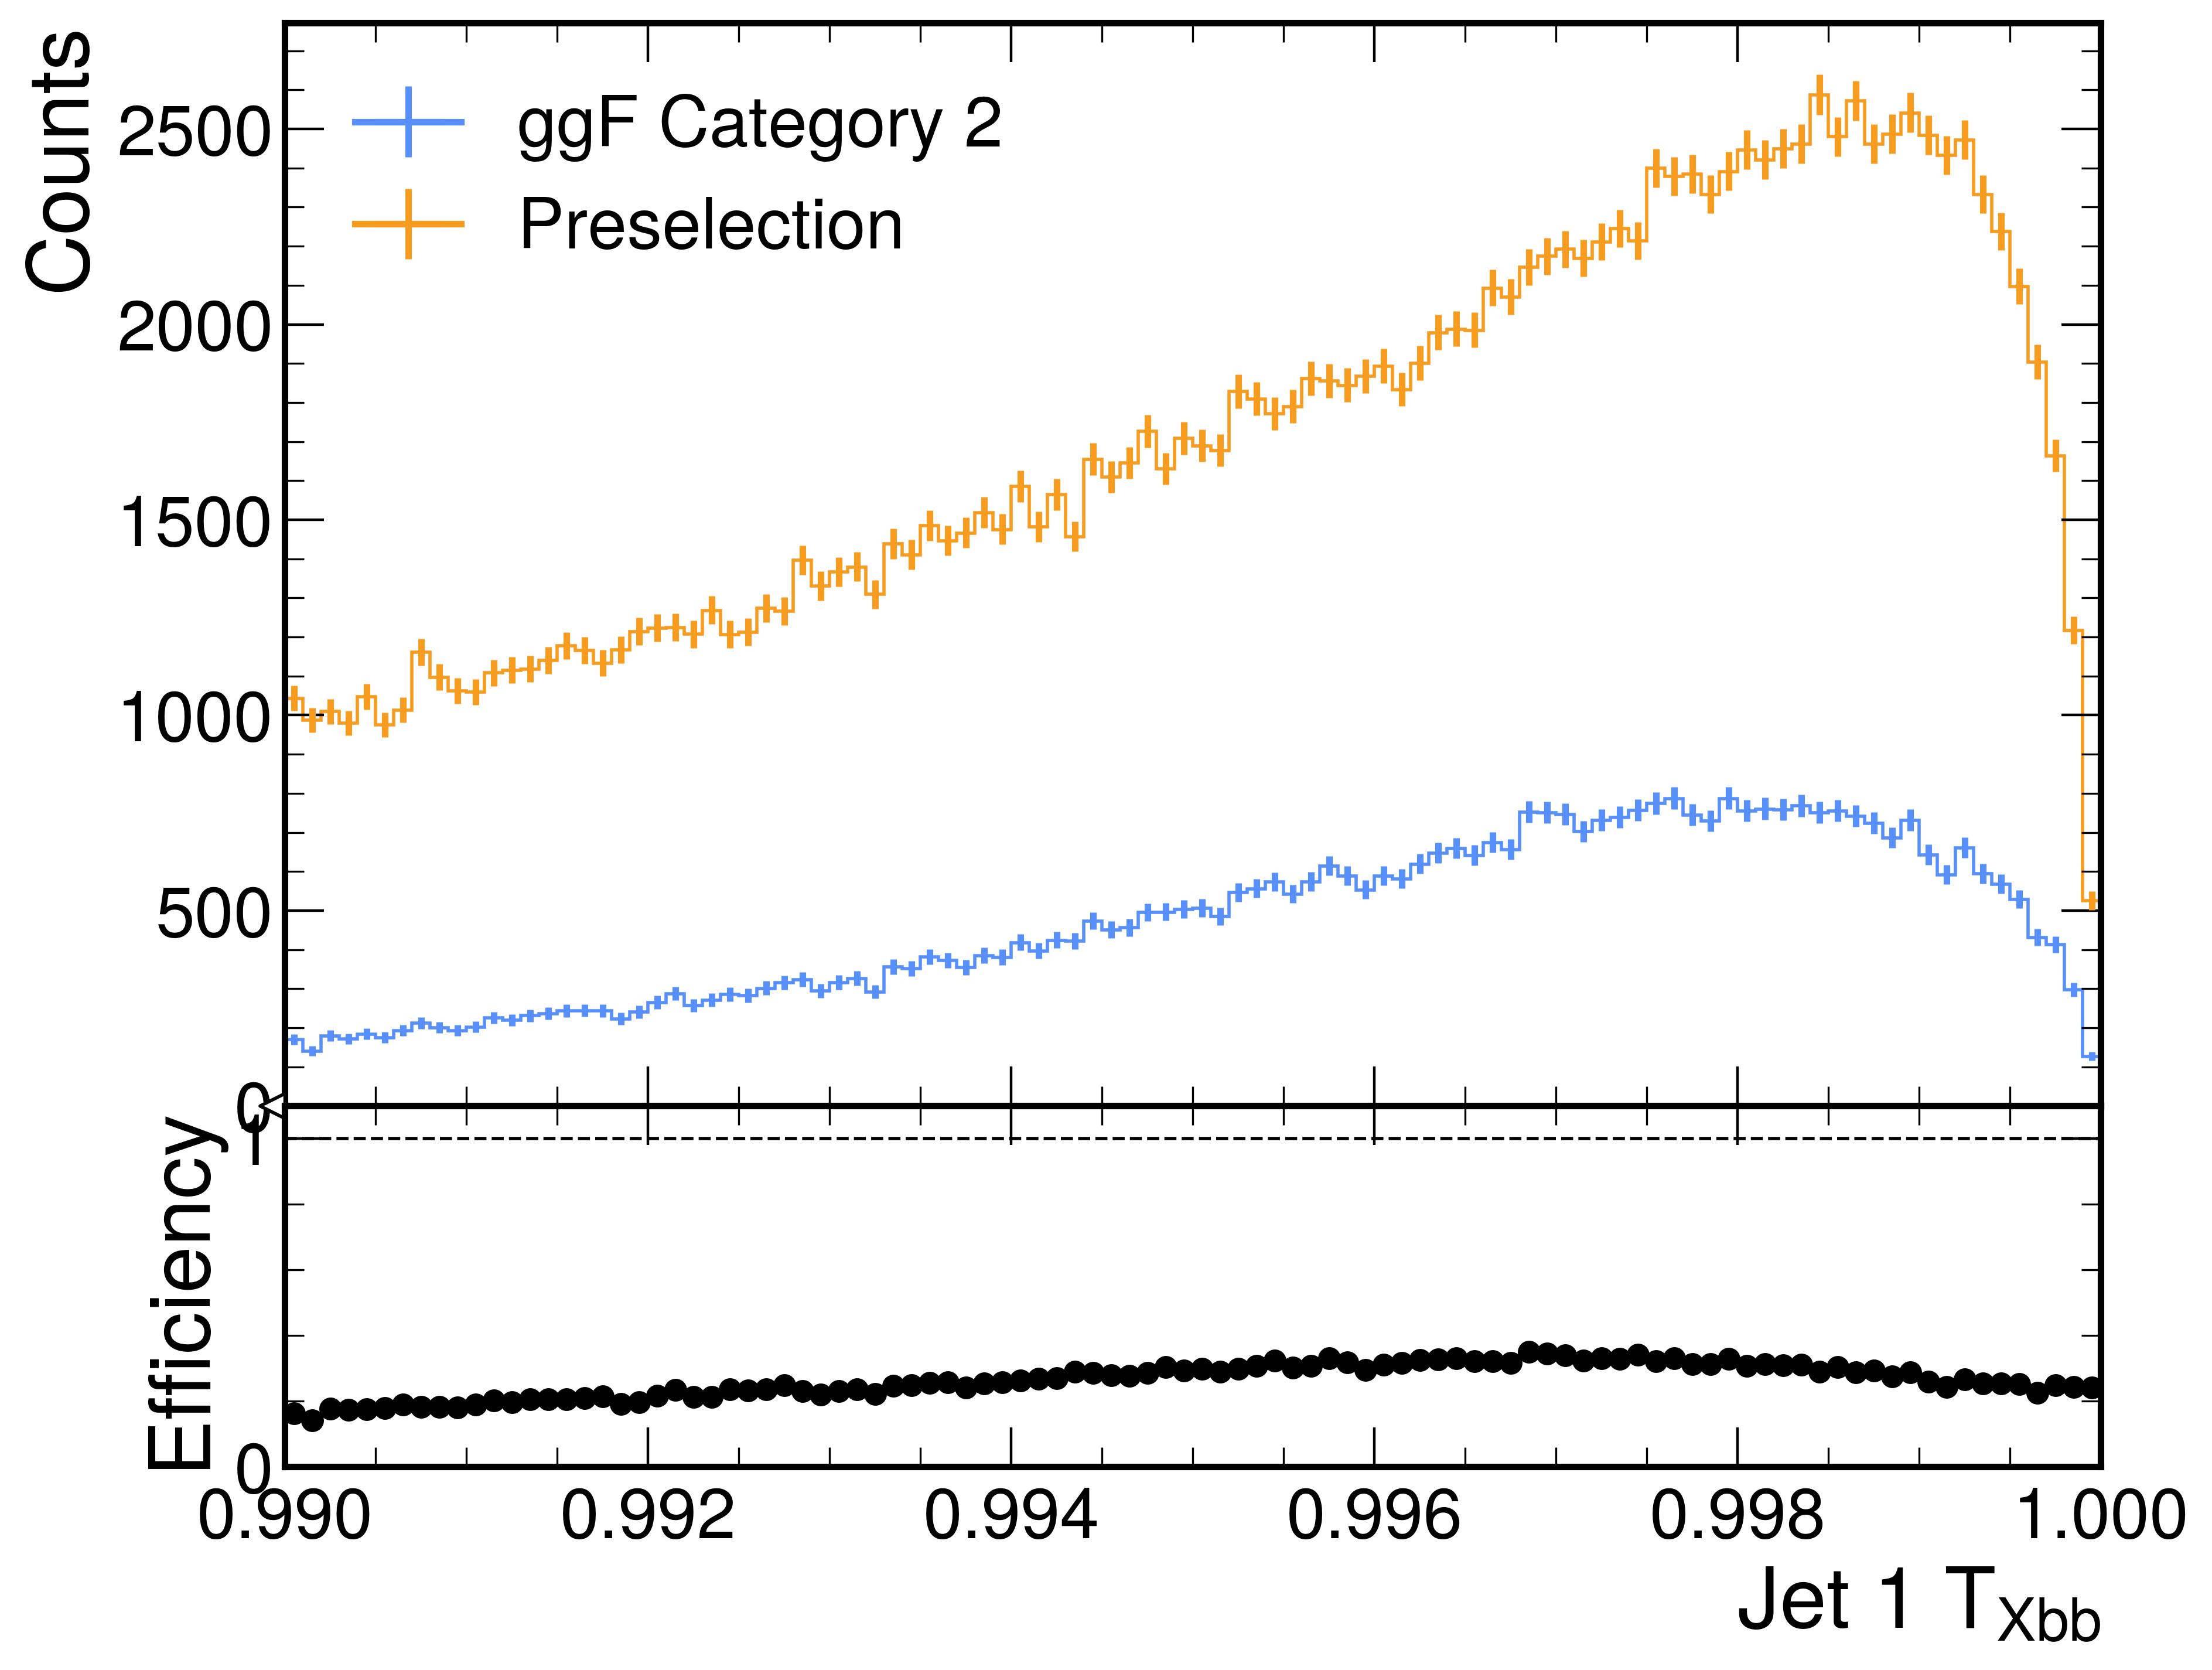

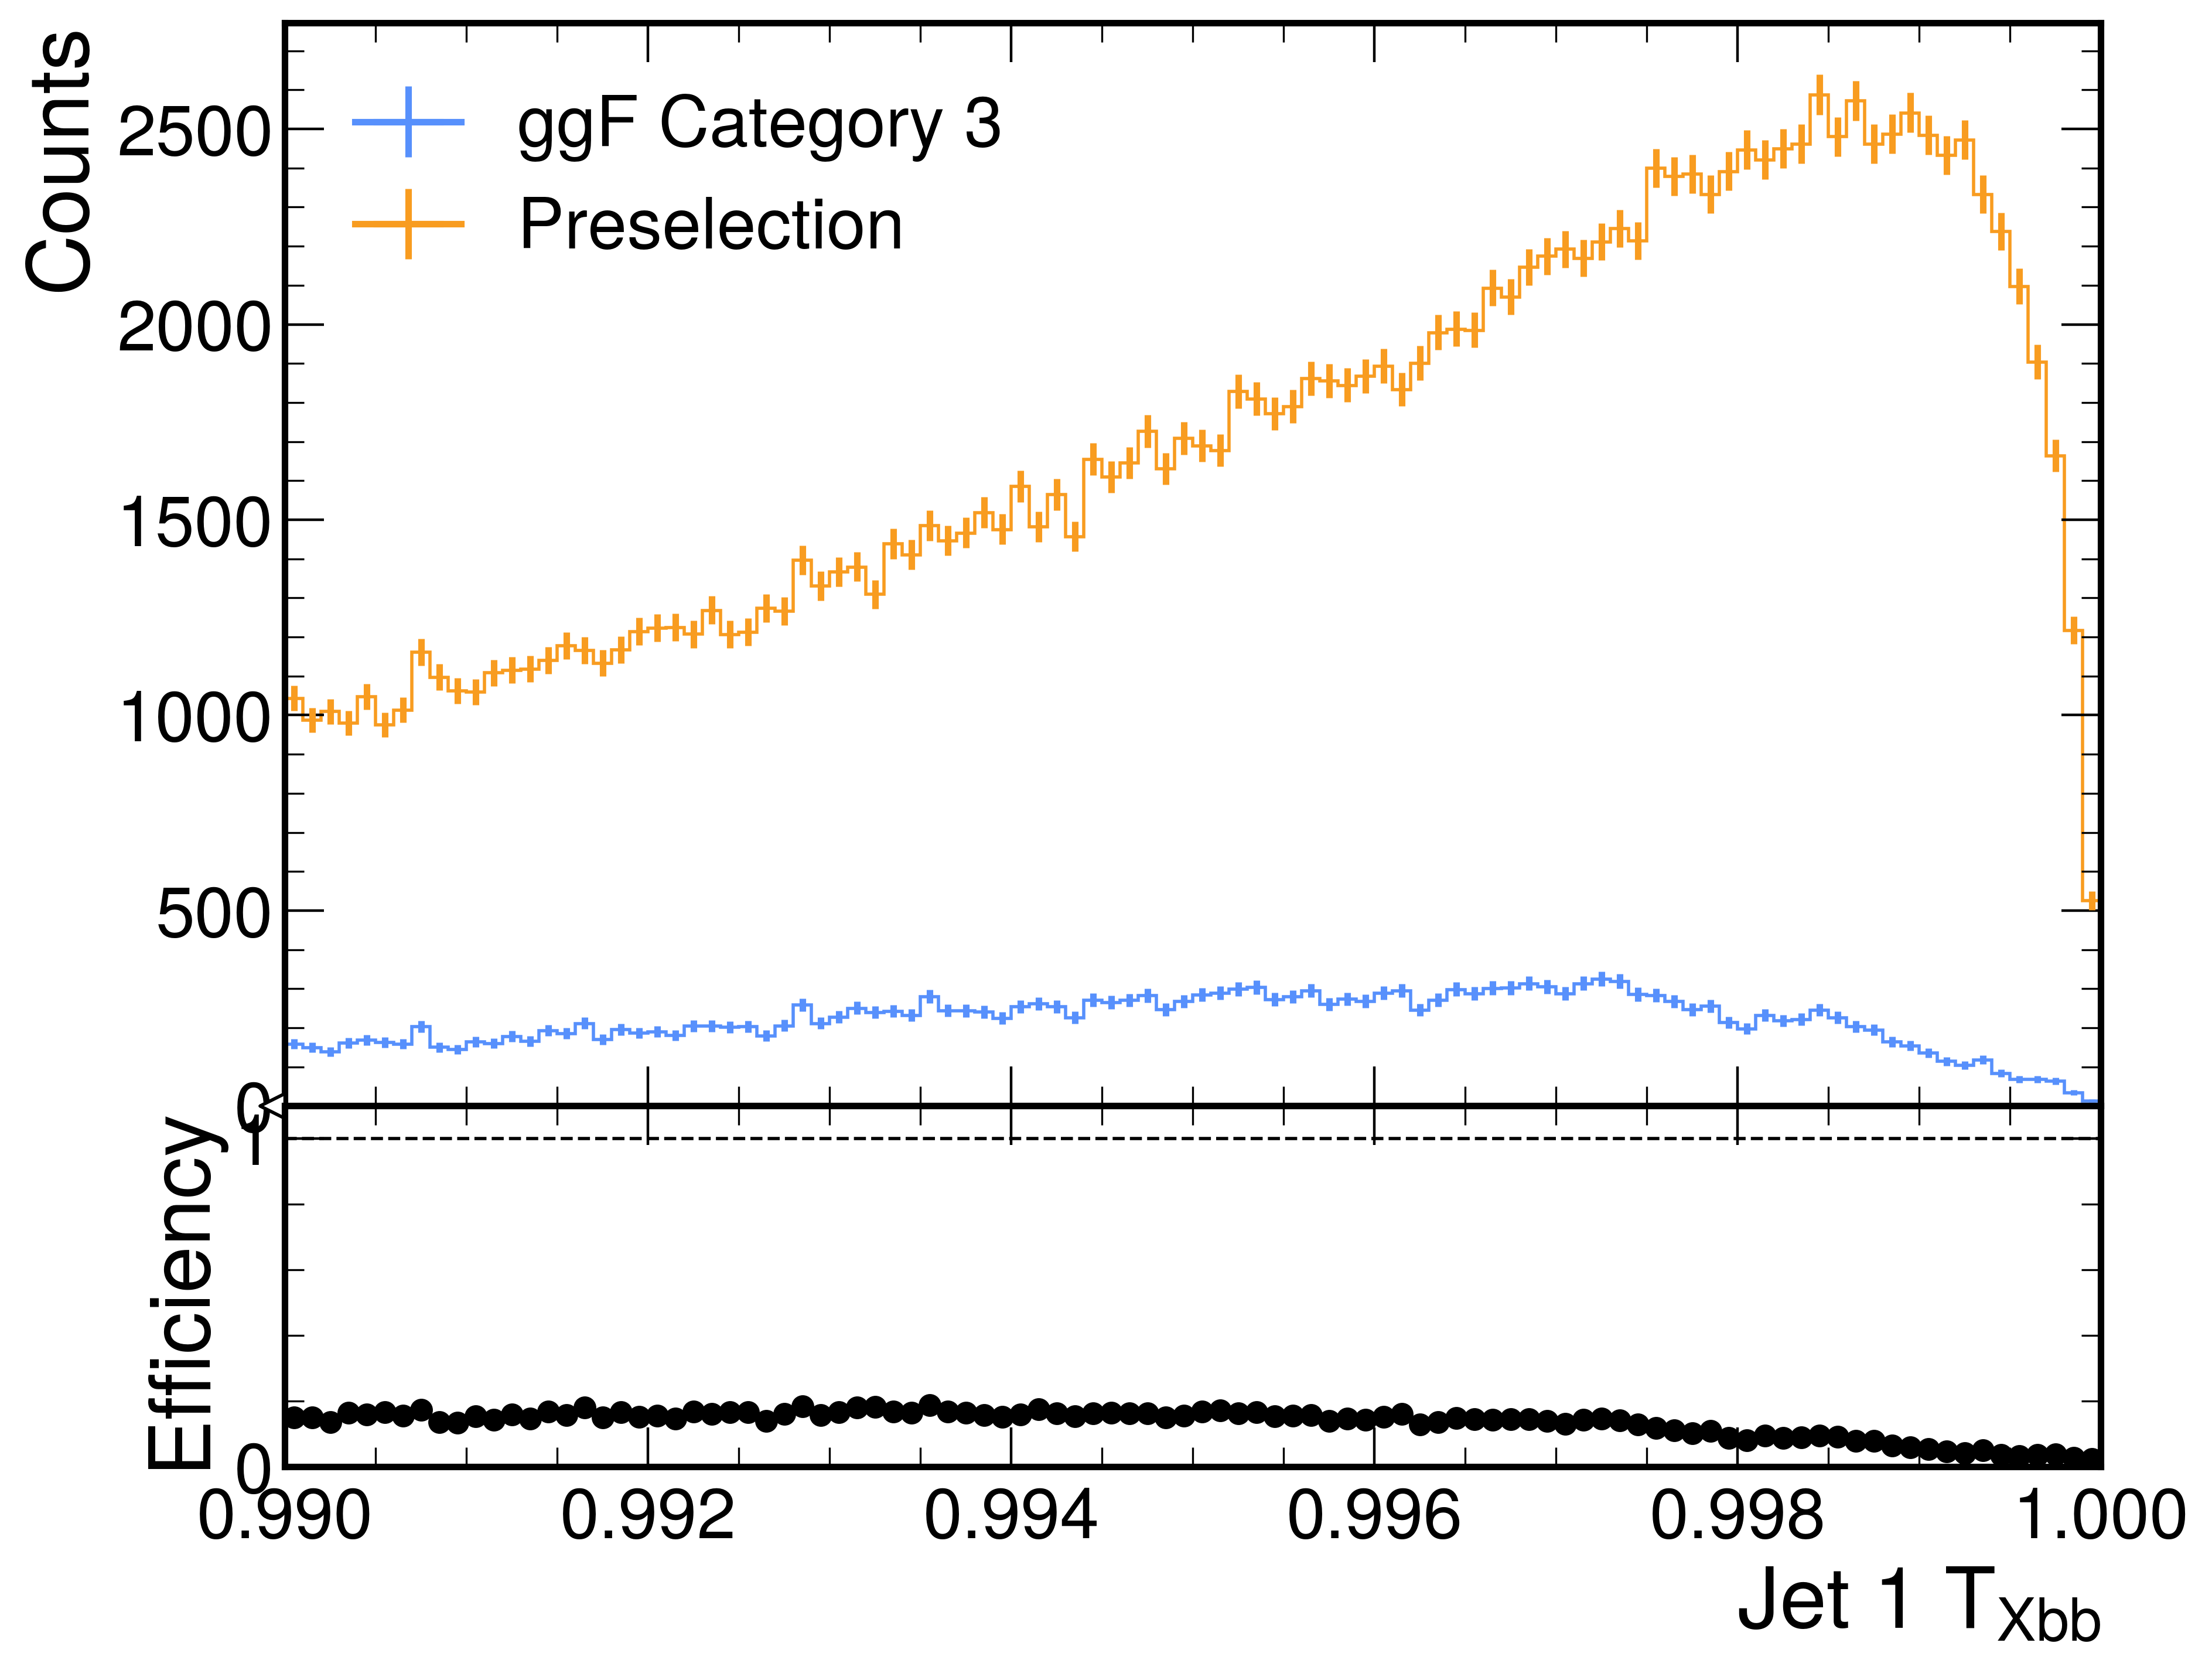

In [23]:
labels = {
    "hh4b": "HH (4b)",
}
bdt_axis = hist.axis.Variable(list(np.arange(0.99, 1, 0.0001)), name="BDT score")
txbb1_axis = hist.axis.Variable(list(np.arange(0.99, 1, 0.0001)), name=r"Jet 1 $T_{Xbb}$")
txbb2_axis = hist.axis.Variable(list(np.arange(0, 1, 0.0001)), name=r"Jet 2 $T_{Xbb}$")


for key, events in events_combined.items():

    h_xbb1_bdt = hist.Hist(txbb1_axis, bdt_axis, storage=hist.storage.Weight())
    h_xbb1_bdt_bin1 = hist.Hist(txbb1_axis, bdt_axis, storage=hist.storage.Weight())
    h_xbb1_bdt_bin2 = hist.Hist(txbb1_axis, bdt_axis, storage=hist.storage.Weight())
    h_xbb1_bdt_bin3 = hist.Hist(txbb1_axis, bdt_axis, storage=hist.storage.Weight())

    h_xbb1 = hist.Hist(txbb1_axis, storage=hist.storage.Weight())
    h_xbb1_bin1 = hist.Hist(txbb1_axis, storage=hist.storage.Weight())
    h_xbb1_bin2 = hist.Hist(txbb1_axis, storage=hist.storage.Weight())
    h_xbb1_bin3 = hist.Hist(txbb1_axis, storage=hist.storage.Weight())

    mask_t2xbb = events["H2TXbb"] > 0.975
    mask_bin1 = (events["H2TXbb"] > 0.975) & (events["bdt_score"] > 0.98)
    mask_bin2 = (~mask_bin1) & (
        ((events["H2TXbb"] > 0.975) & (events["bdt_score"] > 0.88))
        | ((events["H2TXbb"] > 0.92) & (events["bdt_score"] > 0.98))
    )
    mask_bin3 = (
        (~mask_bin1) & (~mask_bin2) & ((events["H2TXbb"] > 0.92) & (events["bdt_score"] > 0.88))
    )

    h_xbb1_bdt.fill(
        events["H1TXbb"],
        events["bdt_score"],
    )
    h_xbb1_bdt_bin1.fill(
        events["H1TXbb"][mask_bin1],
        events["bdt_score"][mask_bin1],
    )
    h_xbb1_bdt_bin2.fill(
        events["H1TXbb"][mask_bin2],
        events["bdt_score"][mask_bin2],
    )
    h_xbb1_bdt_bin3.fill(
        events["H1TXbb"][mask_bin3],
        events["bdt_score"][mask_bin3],
    )

    h_xbb1.fill(events["H1TXbb"])
    h_xbb1_bin1.fill(events["H1TXbb"][mask_bin1])
    h_xbb1_bin2.fill(events["H1TXbb"][mask_bin2])
    h_xbb1_bin3.fill(events["H1TXbb"][mask_bin3])

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    hep.hist2dplot(h_xbb1_bdt, ax=ax)
    ax.set_title(key)

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    hep.hist2dplot(h_xbb1_bdt_bin1, ax=ax)
    ax.set_title(f"{key}, ggF category 1")

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    hep.hist2dplot(h_xbb1_bdt_bin2, ax=ax)
    ax.set_title(f"{key}, ggF category 2")

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    hep.hist2dplot(h_xbb1_bdt_bin3, ax=ax)
    ax.set_title(f"{key}, ggF category 3")

    fig = plt.figure(figsize=(10, 8))
    main_ax_artists, sublot_ax_arists = h_xbb1_bin1.plot_ratio(
        h_xbb1,
        rp_ylabel=r"Efficiency",
        rp_num_label="ggF Category 1",
        rp_denom_label="Preselection",
        rp_uncert_draw_type="line",  # line or bar
        rp_uncertainty_type="efficiency",
    )

    fig = plt.figure(figsize=(10, 8))
    main_ax_artists, sublot_ax_arists = h_xbb1_bin2.plot_ratio(
        h_xbb1,
        rp_ylabel=r"Efficiency",
        rp_num_label="ggF Category 2",
        rp_denom_label="Preselection",
        rp_uncert_draw_type="line",  # line or bar
        rp_uncertainty_type="efficiency",
    )

    fig = plt.figure(figsize=(10, 8))
    main_ax_artists, sublot_ax_arists = h_xbb1_bin3.plot_ratio(
        h_xbb1,
        rp_ylabel=r"Efficiency",
        rp_num_label="ggF Category 3",
        rp_denom_label="Preselection",
        rp_uncert_draw_type="line",  # line or bar
        rp_uncertainty_type="efficiency",
    )

In [24]:
np.quantile(events["H1TXbb"][mask_bin1], q=[0.16, 0.33, 0.5, 0.84])

array([0.99704176, 0.99805737, 0.99865133, 0.99948001])

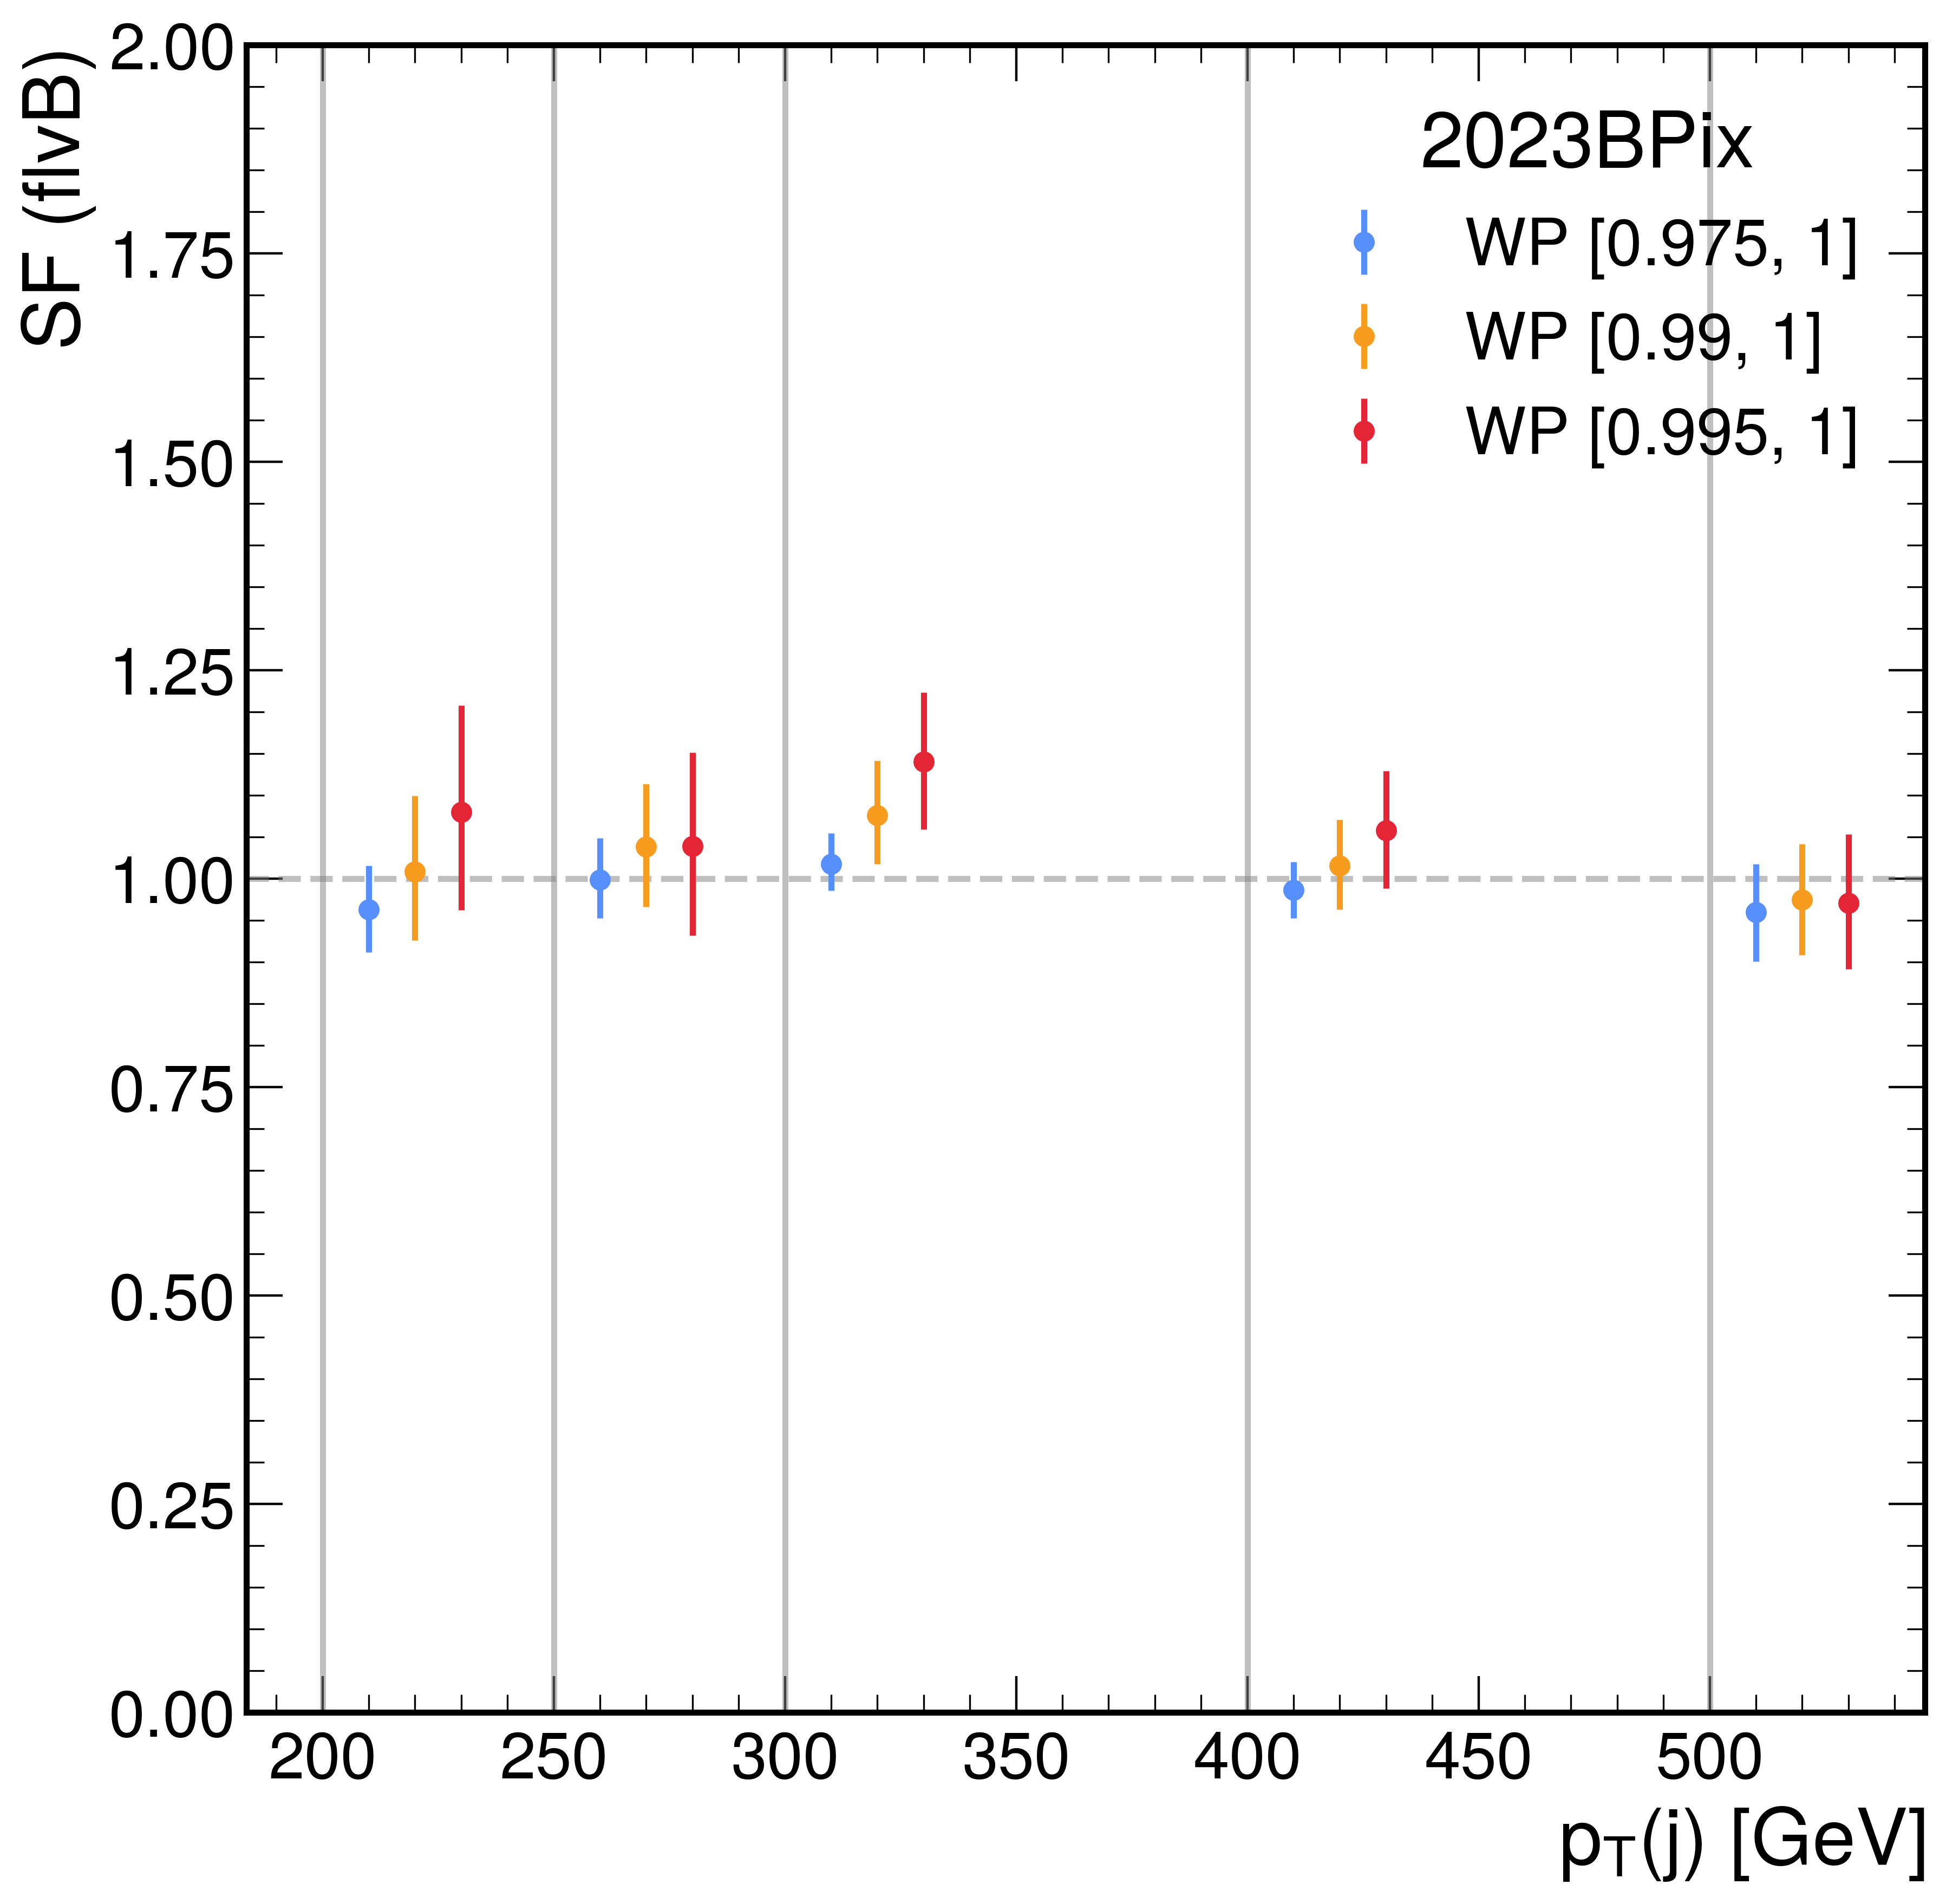

In [25]:
with open(f"{package_path}/corrections/data/txbb_sfs/{year}/sf_txbbv11_Jun14.json") as f:
    txbb_sf_old = json.load(f)
with open(f"{package_path}/corrections/data/txbb_sfs/{year}/sf_txbbv11_Jun26_freezeSFs.json") as f:
    txbb_sf = json.load(f)
with open(
    f"{package_path}/corrections/data/txbb_sfs/{year}/sf_txbbv11_Jun27_freezeSFs_finerWPs.json"
) as f:
    txbb_sf_fine = json.load(f)
with open(
    f"{package_path}/corrections/data/txbb_sfs/{year}/sf_txbbv11_Jun29_freezeSFs_zoomedInWPs.json"
) as f:
    txbb_sf_zoom = json.load(f)
# with open(
#     f"{package_path}/corrections/data/txbb_sfs/{year}/sf_txbbv11_Jul1_freezeSFs_zoomedInWPs998.json"
# ) as f:
#     txbb_sf_zoom998 = json.load(f)

ptbins = np.array([200] + txbbsfs_decorr_pt_bins)
y_old, yerr_low_old, yerr_high_old = [], [], []
y, yerr_low, yerr_high = [], [], []
y_fine, yerr_low_fine, yerr_high_fine = [], [], []
y_zoom, yerr_low_zoom, yerr_high_zoom = [], [], []
# y_zoom998, yerr_low_zoom998, yerr_high_zoom998 = [], [], []
for i in range(len(ptbins) - 1):
    y_old.append(txbb_sf_old[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["central"])
    yerr_low_old.append(txbb_sf_old[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["low"])
    yerr_high_old.append(txbb_sf_old[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["high"])

    y.append(txbb_sf[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["central"])
    yerr_low.append(txbb_sf[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["low"])
    yerr_high.append(txbb_sf[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["high"])

    y_fine.append(txbb_sf_fine[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["central"])
    yerr_low_fine.append(txbb_sf_fine[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["low"])
    yerr_high_fine.append(txbb_sf_fine[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["high"])

    y_zoom.append(txbb_sf_zoom[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["central"])
    yerr_low_zoom.append(txbb_sf_zoom[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["low"])
    yerr_high_zoom.append(txbb_sf_zoom[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["high"])

    # y_zoom998.append(txbb_sf_zoom998[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["central"])
    # yerr_low_zoom998.append(txbb_sf_zoom998[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["low"])
    # yerr_high_zoom998.append(txbb_sf_zoom998[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["high"])


plt.figure()
# horizaontal line at 1
plt.axhline(1, color="gray", linestyle="--", alpha=0.5)
# vertical line at each ptbin
for ptbin in ptbins[:-1]:
    plt.axvline(ptbin, color="gray", linestyle="-", alpha=0.5)
# plt.errorbar(y=y_old, x=ptbins[:-1]-10, yerr=[yerr_low_old, yerr_high_old], fmt="o", label="WP [0.975, 1] old")
plt.errorbar(y=y, x=ptbins[:-1] + 10, yerr=[yerr_low, yerr_high], fmt="o", label="WP [0.975, 1]")
plt.errorbar(
    y=y_fine,
    x=ptbins[:-1] + 20,
    yerr=[yerr_low_fine, yerr_high_fine],
    fmt="o",
    label="WP [0.99, 1]",
)
plt.errorbar(
    y=y_zoom,
    x=ptbins[:-1] + 30,
    yerr=[yerr_low_zoom, yerr_high_zoom],
    fmt="o",
    label="WP [0.995, 1]",
)
# plt.errorbar(
#     y=y_zoom998,
#     x=ptbins[:-1] + 40,
#     yerr=[yerr_low_zoom998, yerr_high_zoom998],
#     fmt="o",
#     label="WP [0.998, 1]",
# )
plt.xlabel("$p_T (j)$ [GeV]")
plt.ylabel("SF (flvB)")
plt.ylim([0, 2])
plt.legend(title=year)

In [26]:
txbb_sf_new = {}
for i in range(len(ptbins) - 1):
    txbb_sf_new[f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"] = txbb_sf_zoom[
        f"WP1_pt{ptbins[i]}to{ptbins[i+1]}"
    ]
    txbb_sf_new[f"WP2_pt{ptbins[i]}to{ptbins[i+1]}"] = txbb_sf_zoom[
        f"WP2_pt{ptbins[i]}to{ptbins[i+1]}"
    ]
    txbb_sf_new[f"WP3_pt{ptbins[i]}to{ptbins[i+1]}"] = txbb_sf_fine[
        f"WP2_pt{ptbins[i]}to{ptbins[i+1]}"
    ]
    txbb_sf_new[f"WP4_pt{ptbins[i]}to{ptbins[i+1]}"] = txbb_sf_fine[
        f"WP3_pt{ptbins[i]}to{ptbins[i+1]}"
    ]
    txbb_sf_new[f"WP5_pt{ptbins[i]}to{ptbins[i+1]}"] = txbb_sf_fine[
        f"WP4_pt{ptbins[i]}to{ptbins[i+1]}"
    ]

with open(
    f"{package_path}/corrections/data/txbb_sfs/{year}/sf_txbbv11_Jul1_freezeSFs_combinedWPs.json",
    "w",
) as f:
    json.dump(txbb_sf_new, f, indent=4)

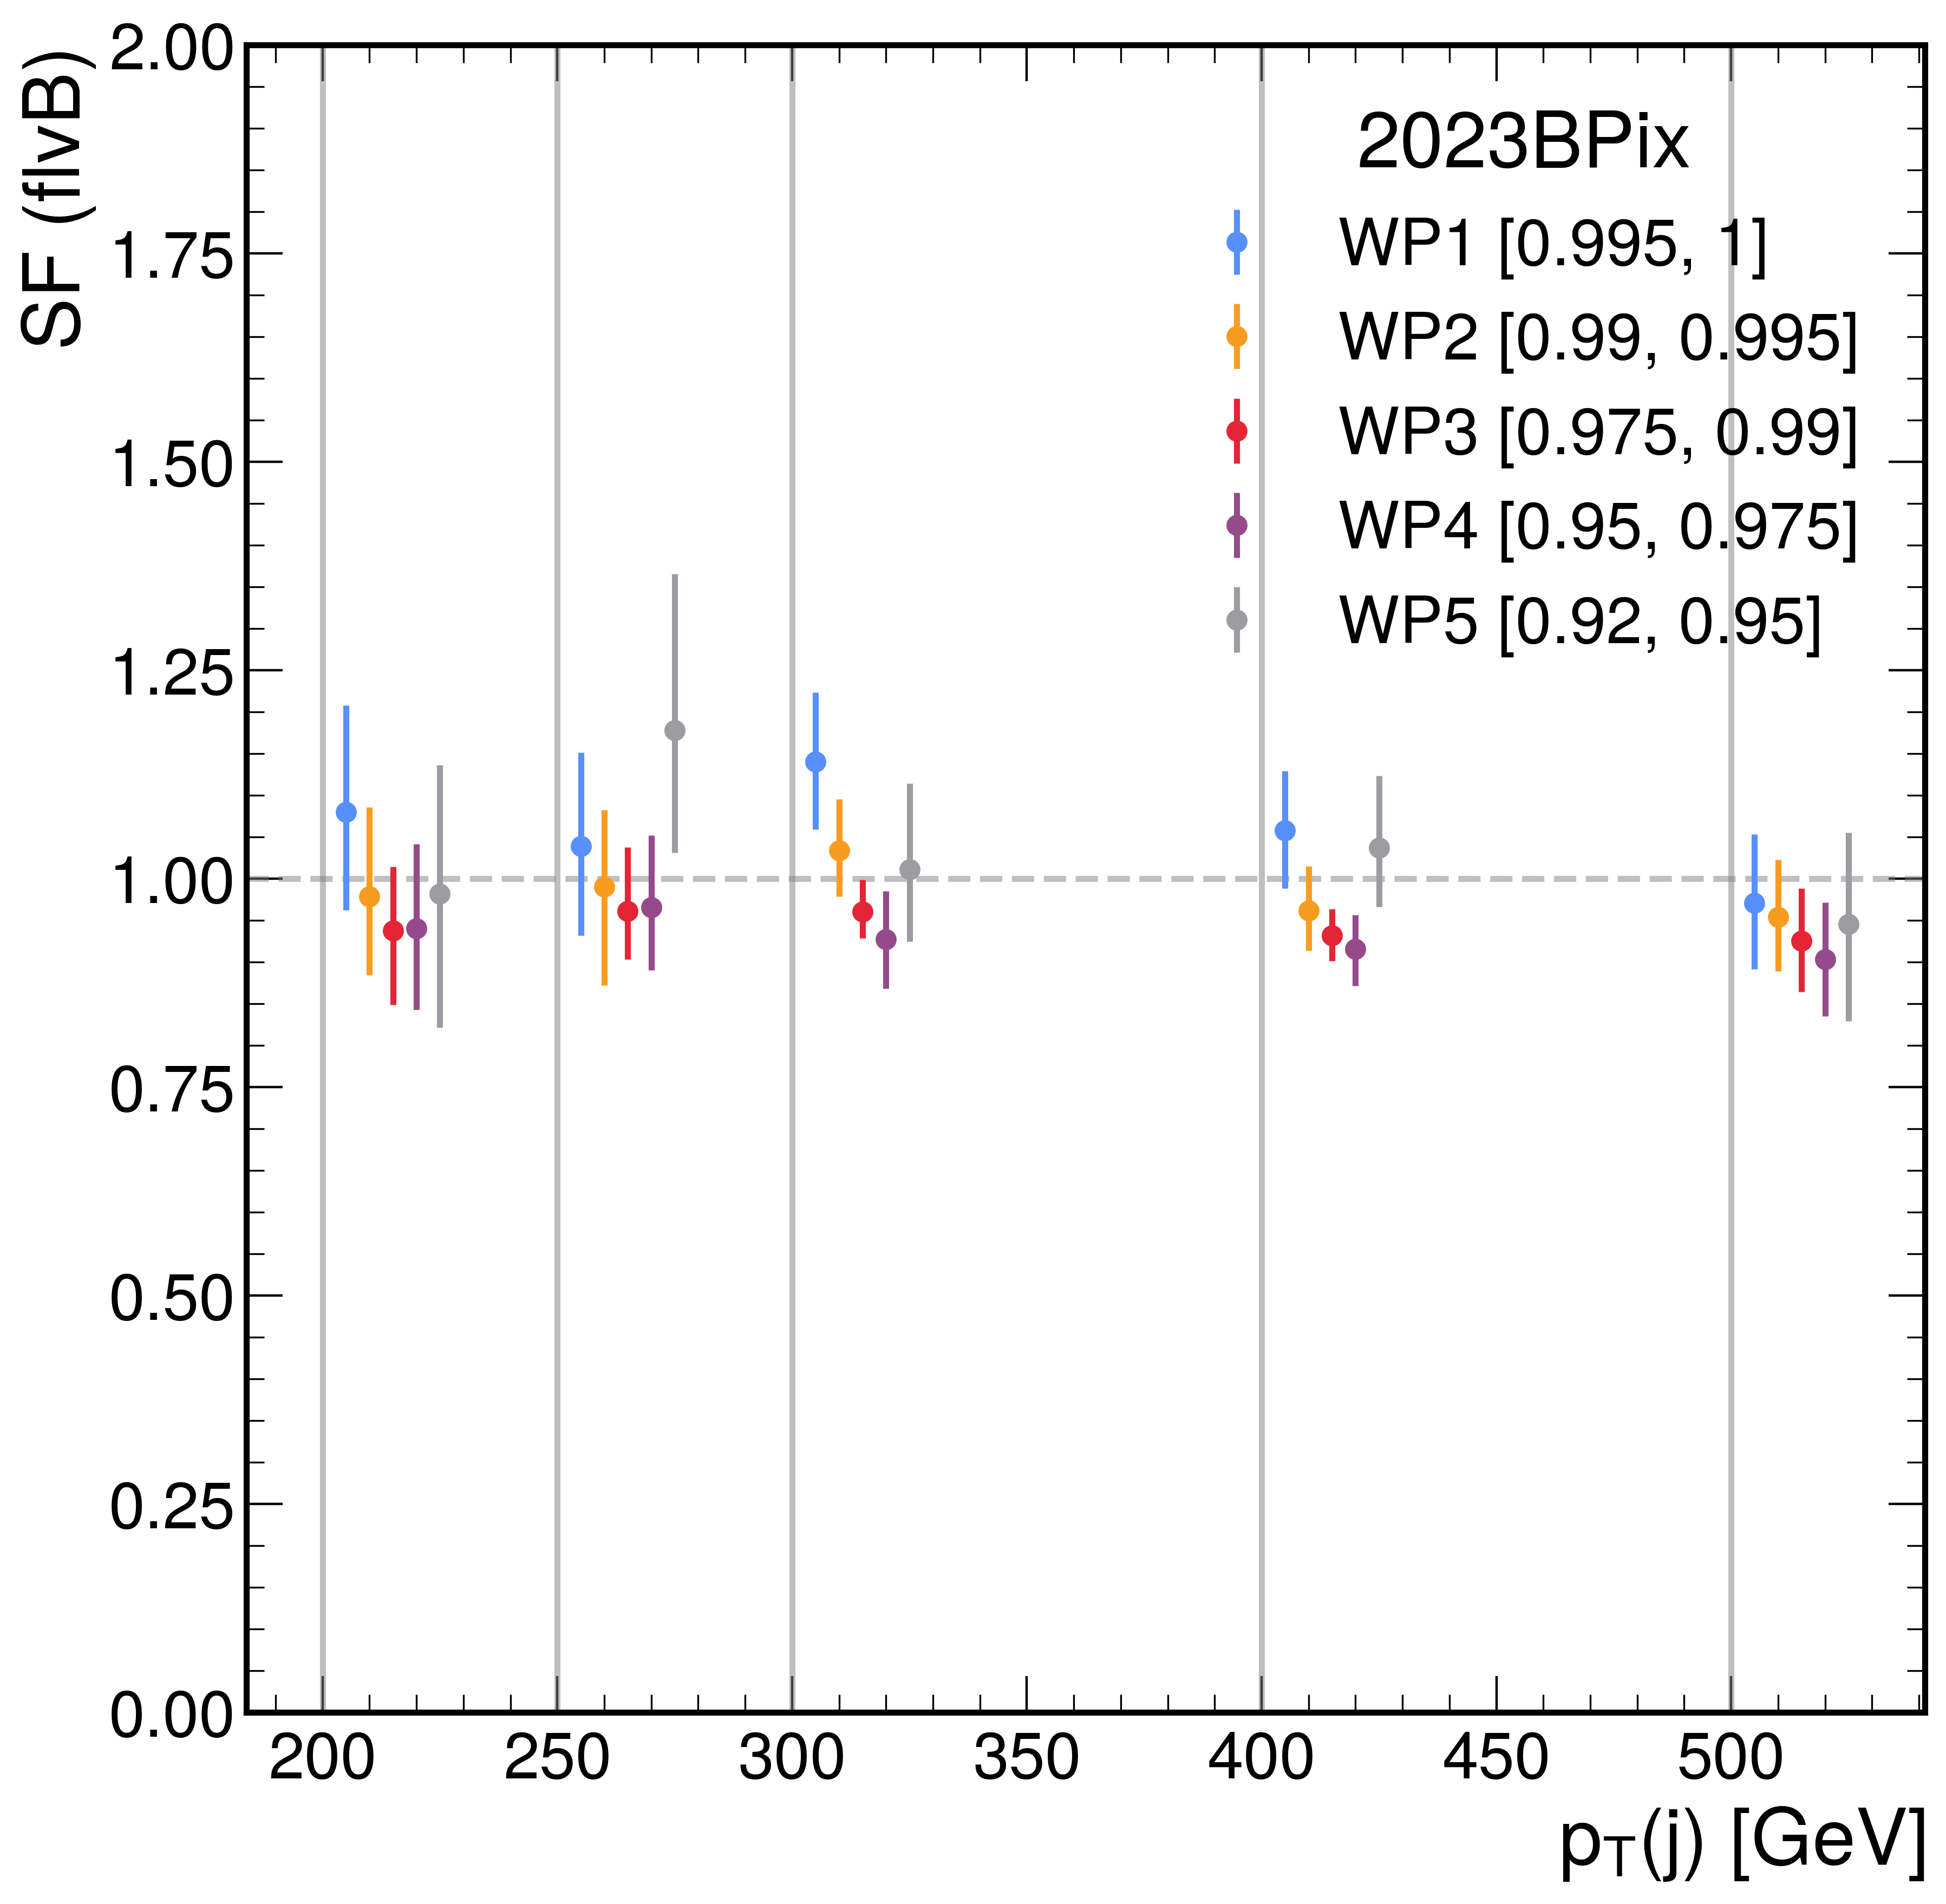

In [27]:
y_new, yerr_low_new, yerr_high_new = [], [], []
wps = {
    "WP1": [0.995, 1],
    "WP2": [0.99, 0.995],
    "WP3": [0.975, 0.99],
    "WP4": [0.95, 0.975],
    "WP5": [0.92, 0.95],
}
for wp in range(0, 5):
    y_new.append([])
    yerr_low_new.append([])
    yerr_high_new.append([])
    for i in range(len(ptbins) - 1):
        y_new[wp].append(txbb_sf_new[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["central"])
        yerr_low_new[wp].append(
            txbb_sf_new[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["low"]
        )
        yerr_high_new[wp].append(
            txbb_sf_new[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["high"]
        )

plt.figure()
# horizaontal line at 1
plt.axhline(1, color="gray", linestyle="--", alpha=0.5)
# vertical line at each ptbin
for ptbin in ptbins[:-1]:
    plt.axvline(ptbin, color="gray", linestyle="-", alpha=0.5)
for wp in range(0, 5):
    plt.errorbar(
        y=y_new[wp],
        x=ptbins[:-1] + (wp + 1) * 5,
        yerr=[yerr_low_new[wp], yerr_high_new[wp]],
        fmt="o",
        label=f"WP{wp+1} {wps[f'WP{wp+1}']}",
    )
plt.xlabel("$p_T (j)$ [GeV]")
plt.ylabel("SF (flvB)")
plt.ylim([0, 2])
plt.legend(title=year)

[0.935, 0.9624999999999999, 0.9824999999999999, 0.9924999999999999, 0.9975]


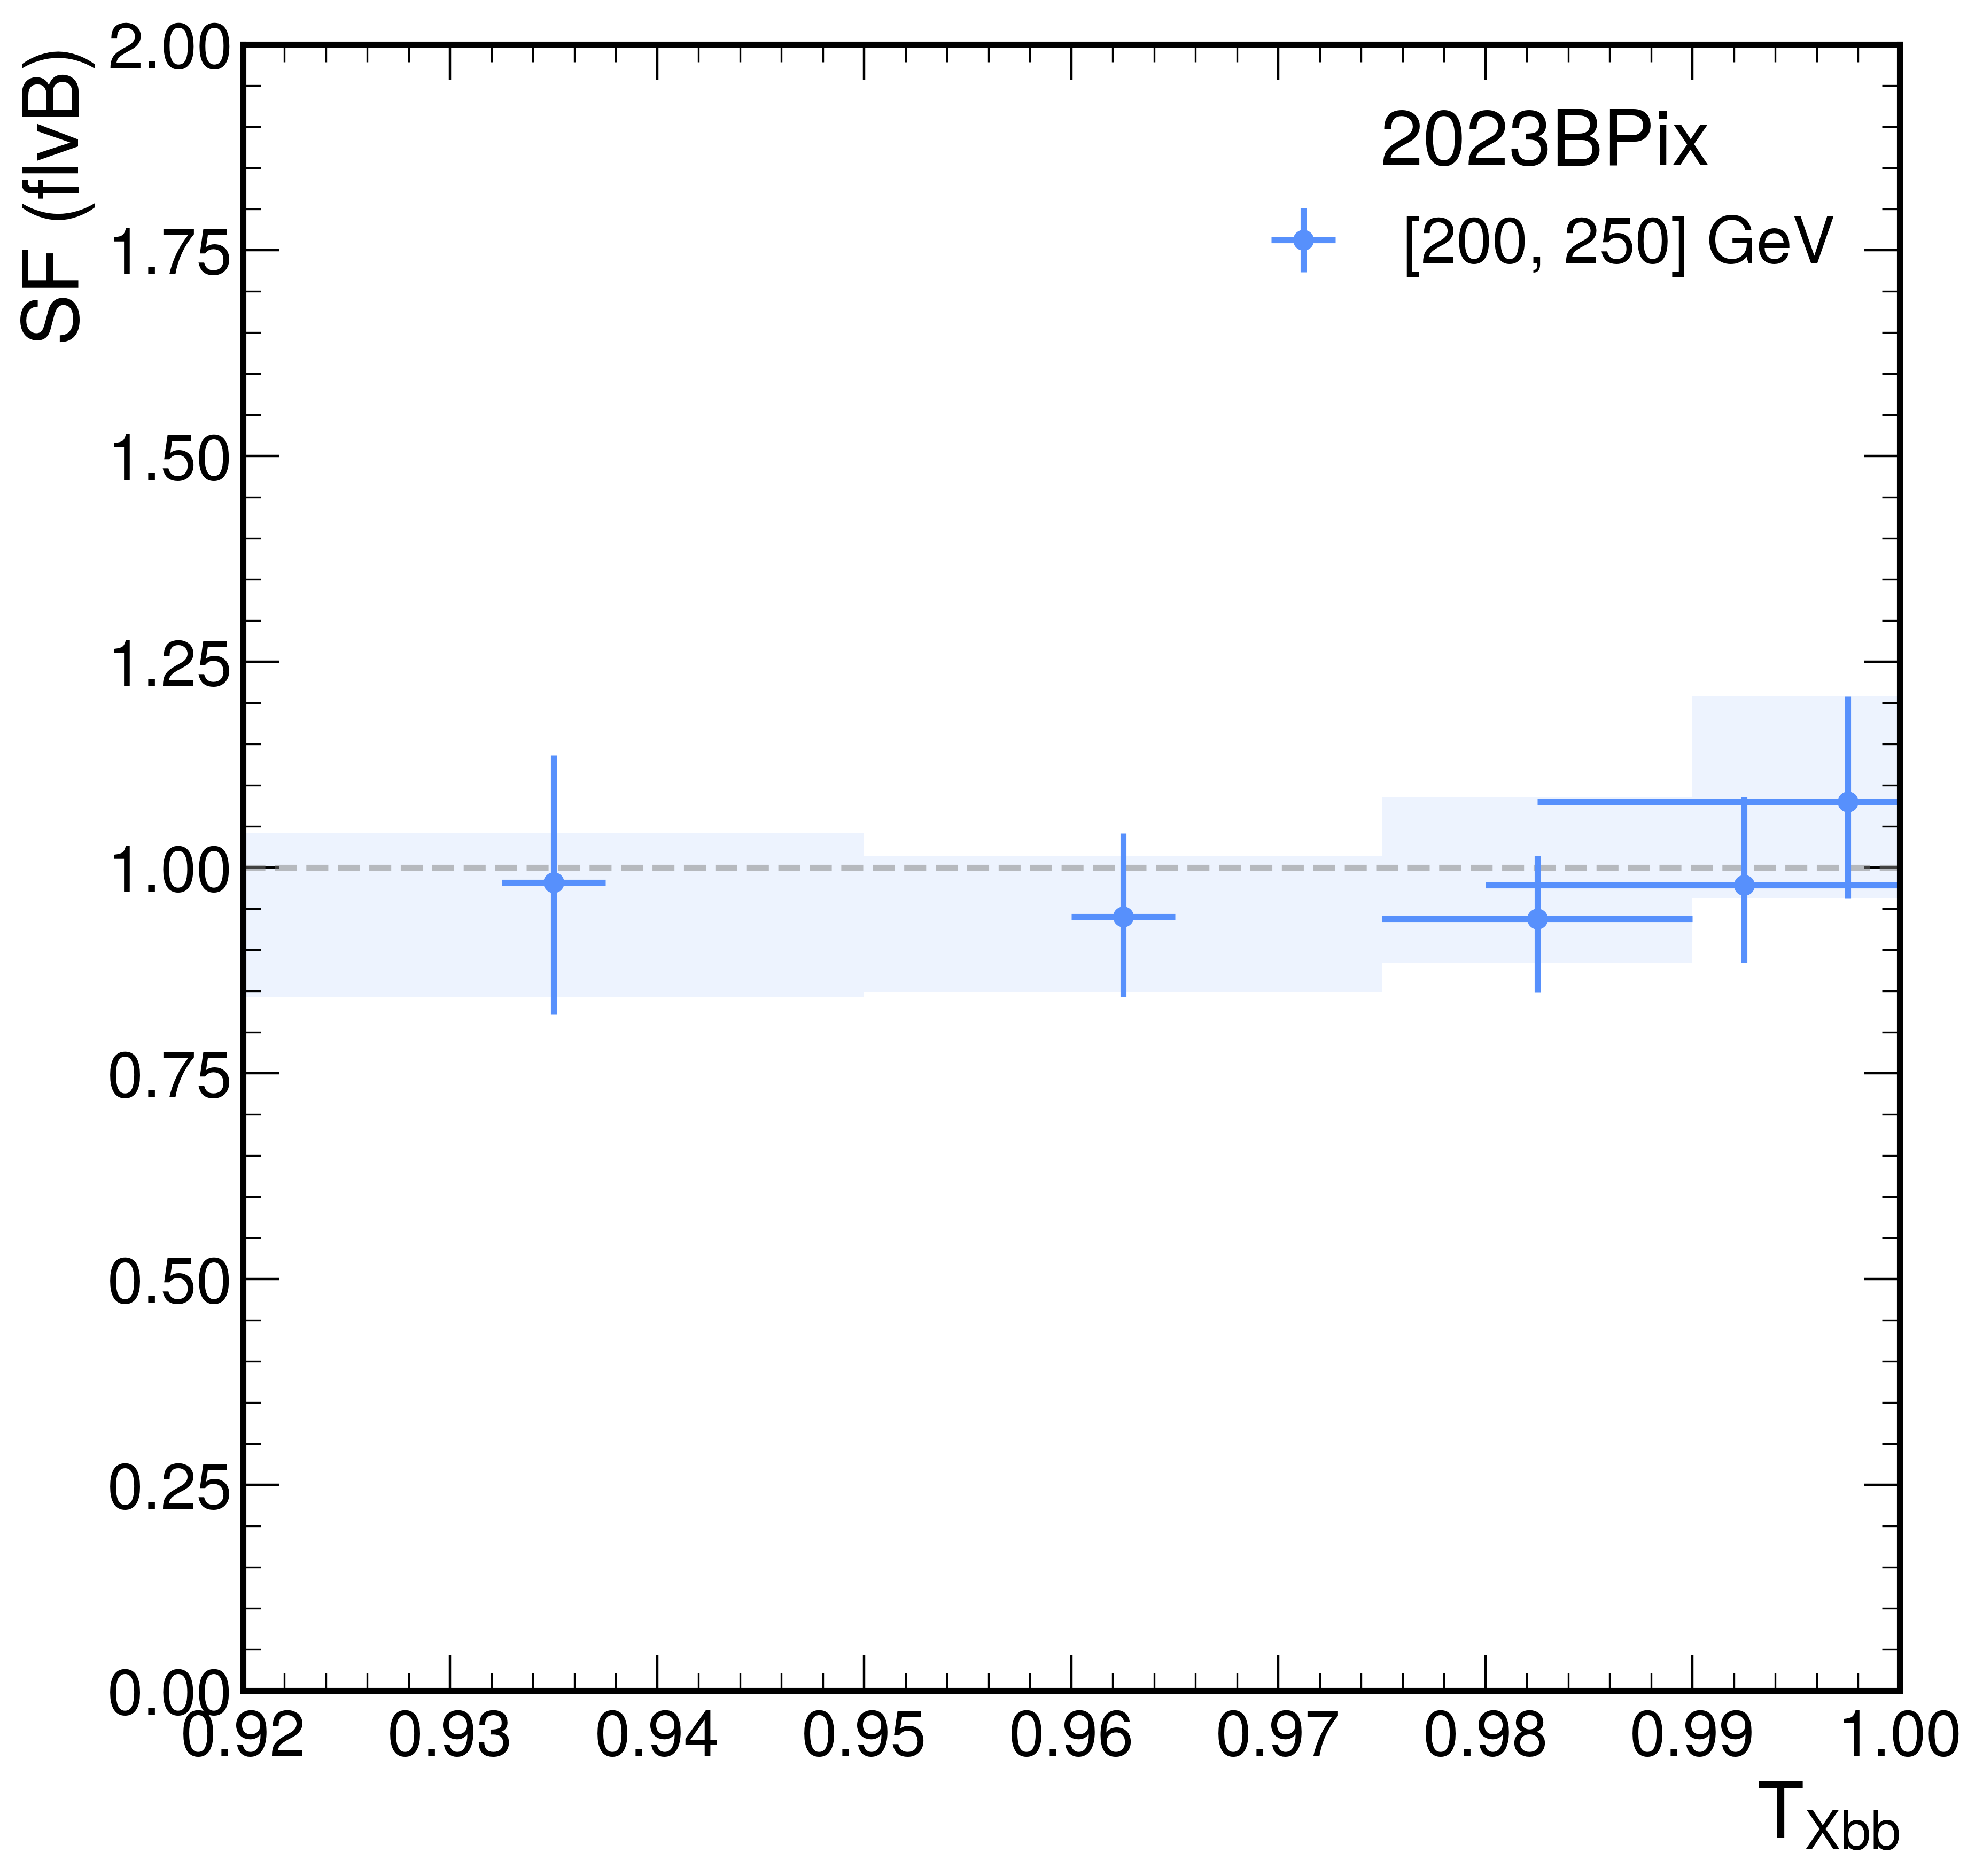

In [78]:
y_new, yerr_low_new, yerr_high_new = [], [], []
wps = {
    "WP1": [0.995, 1],
    "WP2": [0.99, 0.995],
    "WP3": [0.975, 0.99],
    "WP4": [0.95, 0.975],
    "WP5": [0.92, 0.95],
}
for i in range(len(ptbins)-1):
    y_new.append([])
    yerr_low_new.append([])
    yerr_high_new.append([])
    for wp in reversed(range(0, 5)):
        y_new[i].append(txbb_sf_new[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["central"])
        yerr_low_new[i].append(
            txbb_sf_new[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["low"]
        )
        yerr_high_new[i].append(
            txbb_sf_new[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["high"]
        )

plt.figure()
# horizaontal line at 1
plt.axhline(1, color="gray", linestyle="--", alpha=0.5)
for i in [0]:
    x = [np.mean(wps[wp]) for wp in ["WP5", "WP4", "WP3", "WP2", "WP1"]]
    xerr = [(wps[wp][1] - wps[wp][0]) / 2 for wp in ["WP5", "WP4", "WP3", "WP2", "WP1"]]
    print(x)
    plt.errorbar(
        y=y_new[i],
        x=x,
        xerr=xerr,
        yerr=[yerr_low_new[i], yerr_high_new[i]],
        fmt="o",
        label=f"[{ptbins[i]}, {ptbins[i+1]}] GeV".replace("100000","$\inf$"),
    )
    extended_wps = [0.92, 0.95, 0.975, 0.99, 0.995, 1]
    extended_y = np.array(y_new[i] + [y_new[i][-1]])
    extended_yerr_low = np.array(yerr_low_new[i] + [yerr_low_new[i][-1]])
    extended_yerr_high = np.array(yerr_high_new[i] + [yerr_high_new[i][-1]])
    plt.fill_between(
        extended_wps,
        extended_y - extended_yerr_low,
        extended_y + extended_yerr_high,
        alpha=0.1,
        step="pre"
    )
plt.xlabel("$T_{Xbb}$")
plt.ylabel("SF (flvB)")
plt.ylim([0, 2])
plt.xlim([0.92, 1])
plt.legend(title=year)

In [70]:
from HH4b.postprocessing.corrections import _load_txbb_sfs

txbb_sf_func_old = _load_txbb_sfs(
    year, "sf_txbbv11_Jun14", txbbsfs_decorr_txbb_wps, txbbsfs_decorr_pt_bins
)
txbb_sf_func_new = _load_txbb_sfs(
    year, "sf_txbbv11_Jul1_freezeSFs_combinedWPs", wps, txbbsfs_decorr_pt_bins
)

weight_new = txbb_sf_func_new["nominal"](
    events["H1TXbb"].to_numpy(), events["H1Pt"].to_numpy()
) * txbb_sf_func_new["nominal"](events["H2TXbb"].to_numpy(), events["H2Pt"].to_numpy())
weight_old = txbb_sf_func_old["nominal"](
    events["H1TXbb"].to_numpy(), events["H1Pt"].to_numpy()
) * txbb_sf_func_old["nominal"](events["H2TXbb"].to_numpy(), events["H2Pt"].to_numpy())

KeyError: 'WP5_pt250to300'

In [ ]:
weight_new[mask_bin1].sum() / weight_old[mask_bin1].sum()

In [ ]:
ratio = {}
ratio["2022"] = 0.5375997663881179
ratio["2022EE"] = 0.7203077415037246
ratio["2023"] = 1.0558906086460764
ratio["2023BPix"] = 1.033687258950527

In [ ]:
from HH4b.hh_vars import LUMI

sum([ratio[year] * LUMI[year] for year in HH4b.hh_vars.years]) / sum(
    [LUMI[year] for year in HH4b.hh_vars.years]
)

In [ ]:
y_old, yerr_low_old, yerr_high_old = [], [], []
wps = {
    "WP1": [0.975, 1],
    "WP2": [0.95, 0.975],
    "WP3": [0.92, 0.95],
}
for wp in range(0, 3):
    y_old.append([])
    yerr_low_old.append([])
    yerr_high_old.append([])
    for i in range(len(ptbins) - 1):
        y_old[wp].append(txbb_sf[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["central"])
        yerr_low_old[wp].append(txbb_sf[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["low"])
        yerr_high_old[wp].append(txbb_sf[f"WP{wp+1}_pt{ptbins[i]}to{ptbins[i+1]}"]["final"]["high"])

plt.figure()
# horizaontal line at 1
plt.axhline(1, color="gray", linestyle="--", alpha=0.5)
# vertical line at each ptbin
for ptbin in ptbins[:-1]:
    plt.axvline(ptbin, color="gray", linestyle="-", alpha=0.5)
for wp in range(0, 3):
    plt.errorbar(
        y=y_old[wp],
        x=ptbins[:-1] + (wp + 3) * 5,
        yerr=[yerr_low_old[wp], yerr_high_old[wp]],
        fmt="o",
        label=f"WP{wp+1} {wps[f'WP{wp+1}']}",
    )
plt.xlabel("$p_T (j)$ [GeV]")
plt.ylabel("SF (flvB)")
plt.ylim([0, 2])
plt.legend(title=year)